# Necessary Library

In [1]:
import sys
sys.path.append('/Users/wgl/Desktop/t-SNE project code/code/EMBEDR/EMBEDR')

from embedr import EMBEDR


/opt/anaconda3/envs/embed/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(sys.path)

['/opt/anaconda3/envs/embed/lib/python38.zip', '/opt/anaconda3/envs/embed/lib/python3.8', '/opt/anaconda3/envs/embed/lib/python3.8/lib-dynload', '', '/opt/anaconda3/envs/embed/lib/python3.8/site-packages', '/opt/anaconda3/envs/embed/lib/python3.8/site-packages/setuptools/_vendor', '/Users/wgl/Desktop/t-SNE project code/code/EMBEDR/EMBEDR']


In [3]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, pairwise_distances
from sklearn.metrics import davies_bouldin_score
from itertools import combinations
import seaborn as sns

# Data Preprocessing

In [ ]:
data = pd.read_csv("embryoid_body.csv")
data.name = "embryoid_body"
cls = data['cell_type'].astype('category')

In [ ]:
# Load the data
data = pd.read_csv("murine_preprocessed.csv")
data.name = "intestinal"

# Convert the selected columns to a NumPy matrix and transpose it
scale_data = data.iloc[:, 8:2008].to_numpy().T

cls = data['cell_type'].astype('category')

# Applying SVD with k=30
u, s, vt = svds(scale_data, k=30)

# Singular values in descending order
eg_v = s[::-1]  # svds returns them in ascending order

ratios = eg_v[:-1] / eg_v[1:]

# Plot (eg.v[1:29] - eg.v[2:30]) / eg.v[2:30]
differences = (eg_v[:-1] - eg_v[1:]) / eg_v[1:]

# Find the maximum index where the ratio > 1.2
max_index_1_2 = np.max(np.where(ratios > 1.2))
print("Max index where ratio > 1.2:", max_index_1_2)

# Effect of perplexity: find the maximum index where the ratio > 1.1
pc = np.max(np.where(ratios > 1.1)) + 1  # +1 to match R's 1-based index
print("PC (perplexity component):", pc)

# Apply SVD again with k=pc
u_pc, s_pc, vt_pc = svds(scale_data, k=pc)

# Denoise the data: svd.data$v %*% diag(svd.data$d)
data_denoise = vt_pc.T @ np.diag(s_pc)
print("Denoised data shape:", data_denoise.shape)

# Set N=30 (for further analysis if needed)
N = 30

Max index where ratio > 1.2: 3
PC (perplexity component): 10
Denoised data shape: (3452, 10)


# Single Iteration



Initialized EMBEDR.tSNE_Embed object!

Generating null 1 / 1

Initialized EMBEDR.tSNE_Embed object!


<Axes: >

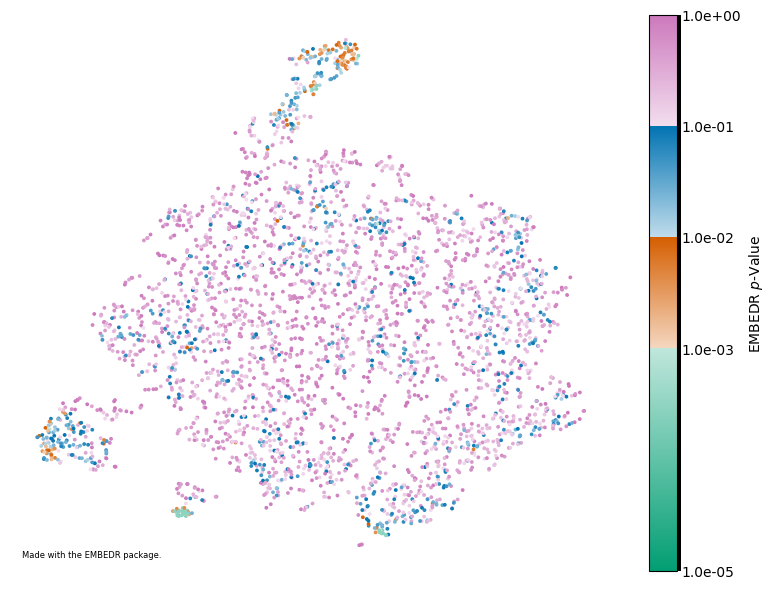

In [129]:
# Create an instance of the EMBEDR class
embObjaa = EMBEDR(perplexity=30, project_dir='./')  # Project directory where results will be stored

# Fit the denoised data using EMBEDR
embObjaa.fit(data_denoise)

# Plot the embedded data
embObjaa.plot()



In [ ]:
# List all attributes of the embObjaa object
print(dir(embObjaa))



['DRA', 'DRA_params', 'EES_params', 'EES_type', 'VALID_AFF', 'VALID_DRAS', 'VALID_EES', 'VALID_pVAL_METHODS', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_allow_sparse', '_calculate_EES_DKL', '_calculate_kEff', '_fit', '_get_asym_local_affmat', '_get_hash', '_get_matchable_UMAP_params', '_get_matchable_tSNE_params', '_get_project_hdr', '_initialize_UMAP_embed', '_initialize_affinity_matrix', '_initialize_kNN_index', '_initialize_tSNE_embed', '_kEff', '_keep_affmats', '_match_UMAP_embeds', '_match_affinity_matrix', '_match_kNN_graph', '_match_tSNE_embeds', '_max_nn', '_nn_arr', '_null_seed', '_pValues', '_perp_arr', '_recalculate_P', '_seed', '_set_hyperparameters', '_set_project_hdr', '_val

In [47]:
embedded_data = embObjaa.data_Y
print(embedded_data)

[[[-0.5741441   9.5872672 ]
  [-1.3508336  14.77229621]
  [-1.45188699 15.60567591]
  ...
  [ 8.62629106 -5.42031488]
  [ 3.87709678 -5.85602173]
  [ 8.71962999 -2.20094649]]]


In [ ]:
# Checking the shape of embedded_data
print("Shape of embedded_data:", embedded_data.shape)

# Remove the unnecessary dimension if present
if embedded_data.shape[0] == 1:
    embedded_data = embedded_data[0]  # Remove the first dimension

# Convert embedded_data to a pandas DataFrame
if embedded_data.shape[1] == 2:
    embedded_df = pd.DataFrame(embedded_data, columns=['Dimension 1', 'Dimension 2'])
    print(embedded_df.head())  # Display the first few rows of the DataFrame
else:
    print("Error: The embedded data does not have the correct shape for conversion.")


Shape of embedded_data: (3452, 2)
   Dimension 1  Dimension 2
0    -0.574144     9.587267
1    -1.350834    14.772296
2    -1.451887    15.605676
3     6.505390    -8.353107
4     8.393001     0.151942


In [ ]:
# Create an instance of NearestNeighbors and fit it to the data
nbrs = NearestNeighbors(n_neighbors=50, algorithm='auto').fit(embedded_df)

# Find the nearest neighbors for each point in Y
distances, indices = nbrs.kneighbors(embedded_df)

# Convert the indices to a DataFrame with 50 columns and n_samples rows
knn_df = pd.DataFrame(indices, columns=[f'Neighbor_{i+1}' for i in range(50)])

# Display the resulting DataFrame
print(knn_df)



      Neighbor_1  Neighbor_2  Neighbor_3  Neighbor_4  Neighbor_5  Neighbor_6  \
0              0          86         127          41        2408        1791   
1              1        1051        1058        1664        1341        1557   
2              2         163         128         182         953        1563   
3              3         300         328        3282        2986         248   
4              4         348          17        2037        1648        2416   
...          ...         ...         ...         ...         ...         ...   
3447        3447        2818        2915         403        2747        2051   
3448        3448        1585        2066        3145         987        1786   
3449        3449        1537        2879         757         800        2894   
3450        3450        2896        3247         823         401        1388   
3451        3451        1569        3016        1603        2707        3394   

      Neighbor_7  Neighbor_8  Neighbor_

# Multiple Iterations

In [ ]:
# Set random seed for reproducibility
np.random.seed(123)

# Define GCP (list of perplexities) and N (number of iterations)
GCP = [2,3,5,10,30,50,100,300,500] 
N = 30  

# Loop over each value in GCP (similar to R code)
for perp in GCP:
    knn_mat = []  # Store the k-NN indices for each iteration
    Y_mat = []    # Store the Y (embedded data) for each iteration

    # Iterate N times to generate embeddings and calculate k-NN
    for i in range(N):
        # Set a unique seed for each iteration to generate different embeddings
        iteration_seed = i

        # Create an instance of EMBEDR with the given perplexity and iteration-specific seed
        embObj = EMBEDR(perplexity=perp, project_dir='./', random_state=iteration_seed)
    
        embObj.fit(data_denoise)

        # Get the Y matrix for embedding
        embedded_data = embObj.data_Y

        # Remove the first dimension if needed
        if embedded_data.shape[0] == 1:
            embedded_data = embedded_data[0]

        # Ensure the embedded data is in the correct shape (n_samples, 2)
        if embedded_data.shape[1] == 2:
            embedded_df = pd.DataFrame(embedded_data, columns=['Dimension 1', 'Dimension 2'])
        else:
            raise ValueError("Error: The embedded data does not have the correct shape for conversion.")

        # Append the current embedded DataFrame to Y_mat
        Y_mat.append(embedded_df)

        # Find the k-nearest neighbors (k = 50)
        k = 50
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(embedded_df)

        # Find the nearest neighbors for each point in embedded data
        _, indices = nbrs.kneighbors(embedded_df)

        # Convert the indices to a DataFrame with 50 columns and n_samples rows
        knn_df = pd.DataFrame(indices, columns=[f'Neighbor_{n+1}' for n in range(k)])

        # Store the k-NN indices
        knn_mat.append(knn_df)

        # Print progress
        print(f"Iteration: {i+1}, Perplexity: {perp}")

    # Save knn_mat and Y_mat to a file
    output_file = f"{embObj.project_name}_tsne_random_p{perp}_pc{embObj.n_components}_knnMat_Y.pkl"
    with open(output_file, 'wb') as f:
        pickle.dump({'knn_mat': knn_mat, 'Y_mat': Y_mat}, f)

print("Processing complete.")


---> Finding 11 nearest neighbors to query points in existing kNN graph using an approximate search and the 'euclidean'' metric...
---> Time Elapsed: 0.26 seconds!
---> Calculating fixed-entropy Gaussian affinity matrix!
---> Time Elapsed: 0.01 seconds!

Initialized EMBEDR.tSNE_Embed object!
---> Calculating fixed-entropy Gaussian affinity matrix!
---> Time Elapsed: 0.0079 seconds!

Fitting embedding 1/1 (1 total requested).

Initialized EMBEDR.tSNE_Embed object!

Generating 2-dimensional embedding with t-SNE!
---> Fitting t-SNE for up to 250 iterations with exaggeration = 12.0 and learning rate = 287.7.
Itr   50, DKL 6.7514,	50 iterations in 0.3714 sec
---> Time Elapsed: 0.8 seconds!
Optimization interrupted by callback
---> Fitting t-SNE for up to 1000 iterations with exaggeration = 1.0 and learning rate = 287.7.
Itr   50, DKL 3.5336,	50 iterations in 0.4140 sec
Itr  100, DKL 2.7750,	50 iterations in 0.3828 sec
Itr  150, DKL 2.3900,	50 iterations in 0.6654 sec
Itr  200, DKL 2.1759,	

In [112]:
# Initialize lists to store the scores
knn_s = []
stab_s = []
concord_s = []
sil_s = []
cor_s = []
db_s = []

# Loop through each perplexity value (GCP)
for perp in GCP:
    # Load the knn_mat and embedded data from the pickled file
    filename = f"EMBEDR_project_tsne_random_p{perp}_pc2_knnMat_Y.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    knn_mat = data['knn_mat']  # List of DataFrames, each containing k-NN indices
    Y_mat = data['Y_mat']  # List of embedded DataFrames

    # Use the first embedded DataFrame as Y for the following analysis (you can choose other iterations as well)
    embedded_df = Y_mat[0]  # For example, use the first iteration
    Y = embedded_df.values

    # Step 1: Construct k-NN graph
    n_samples = knn_mat[0].shape[0]
    knn_graph = np.zeros((n_samples, n_samples))

    for knn_df in knn_mat:
        for j in range(n_samples):
            neighbors = knn_df.iloc[j, :].values
            knn_graph[j, neighbors] += 1

    knn_graph = np.maximum(knn_graph, knn_graph.T)  # Ensure symmetry

    # Step 2: Calculate k-NN score for each point
    knn_score = []
    for i in range(n_samples):
        non_zero_indices = knn_graph[i, :] != 0
        if np.any(non_zero_indices):  # Ensure there are non-zero values
            score = np.quantile(knn_graph[i, non_zero_indices] / N, 0.75)
            knn_score.append(score)

    knn_s.append(np.mean(knn_score))

    # Step 3: Calculate stability score for different iterations
    temp_out = np.zeros((N, N))
    for i, j in combinations(range(N), 2):
        temp = []
        for m in range(n_samples):
            intersection = len(set(knn_mat[i].iloc[m, :50]).intersection(set(knn_mat[j].iloc[m, :50])))
            temp.append(intersection / 50)
        temp_out[i, j] = np.median(temp)

    stab_s.append(np.nanmean(temp_out))

    # Step 4: Calculate true concordance between high and low dimensional data
    k = 100
    nbrs_high = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(data_denoise)
    _, knn_h = nbrs_high.kneighbors(data_denoise)

    nbrs_low = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(Y)
    _, knn_l = nbrs_low.kneighbors(Y)

    concord_score = []
    for i in range(n_samples):
        concord = len(set(knn_h[i, :]).intersection(set(knn_l[i, :]))) / k
        concord_score.append(concord)

    concord_s.append(np.mean(concord_score))

    # Step 5: Calculate silhouette score
    sil_scores = silhouette_samples(Y, np.array(cls))
    sil_s.append(np.mean(sil_scores))

    # Step 6: Calculate correlation between distances in high and low dimensions
    high_dim_distances = pairwise_distances(data_denoise).ravel()
    low_dim_distances = pairwise_distances(Y).ravel()
    cor_s.append(np.corrcoef(high_dim_distances, low_dim_distances)[0, 1])

    # Step 7: Calculate Davies-Bouldin index
    db_s.append(1 / davies_bouldin_score(Y, np.array(cls)))

    print(f"Finished GCP: {perp}")

# Print final scores
print("KNN Stability Scores:", knn_s)
print("Stability Scores:", stab_s)
print("Concordance Scores:", concord_s)
print("Silhouette Scores:", sil_s)
print("Correlation Scores:", cor_s)
print("Davies-Bouldin Scores:", db_s)


Finished GCP: 2
Finished GCP: 3
Finished GCP: 5
Finished GCP: 10
Finished GCP: 30
Finished GCP: 50
Finished GCP: 100
Finished GCP: 300
Finished GCP: 500
KNN Stability Scores: [0.11308178833526458, 0.22206450366937042, 0.4082560834298958, 0.617501931247586, 0.8127510621861723, 0.8206426226342218, 0.6218737929702588, 0.5152592699884125, 0.6359839706450368]
Stability Scores: [0.20095555555555553, 0.2500333333333334, 0.29628888888888893, 0.34936666666666666, 0.3941555555555556, 0.39690000000000003, 0.35126666666666667, 0.3197333333333333, 0.35236666666666666]
Concordance Scores: [0.2987050984936269, 0.32847045191193514, 0.366491888760139, 0.40393974507531866, 0.4337833140208575, 0.4517757821552723, 0.45924391657010427, 0.4631517960602549, 0.453018539976825]
Silhouette Scores: [-0.21709205354569042, -0.23979502146899953, -0.18325933767657693, -0.14675051892111457, -0.1072320820712289, -0.09364054386553046, -0.09679615096971671, -0.07762654128694328, -0.06177169163565951]
Correlation Scores:

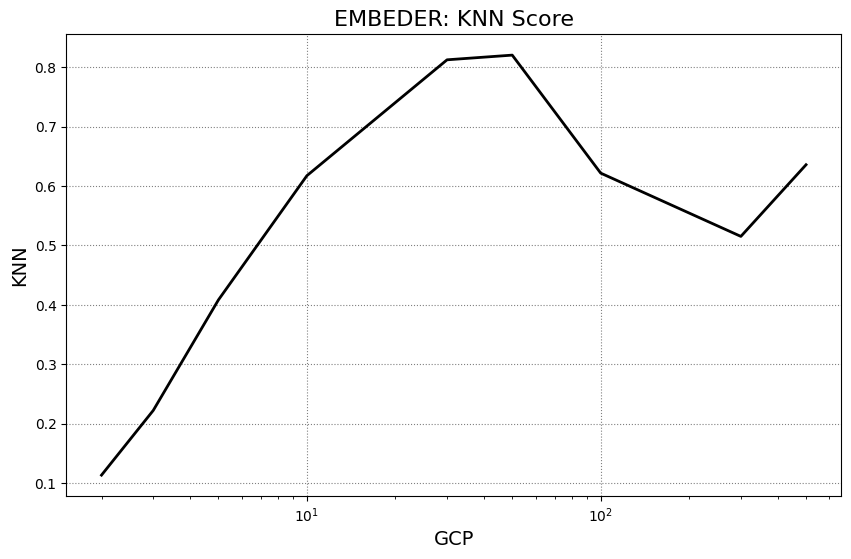

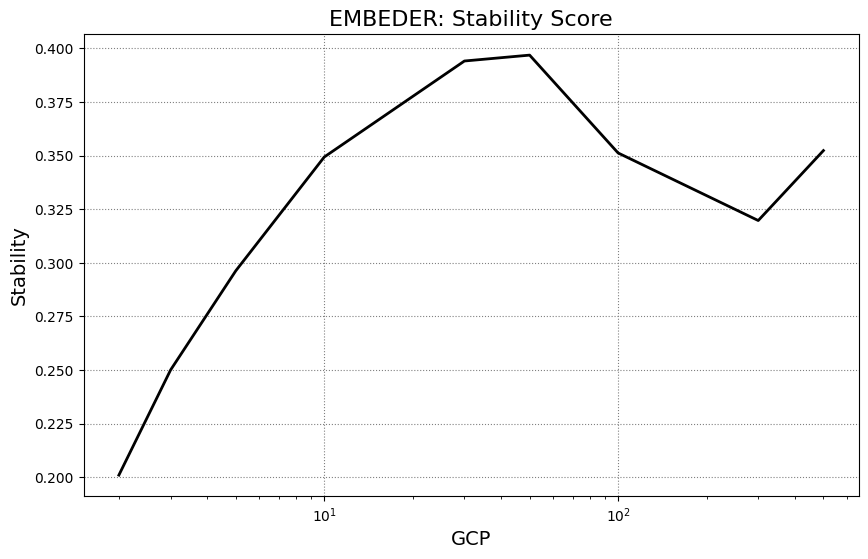

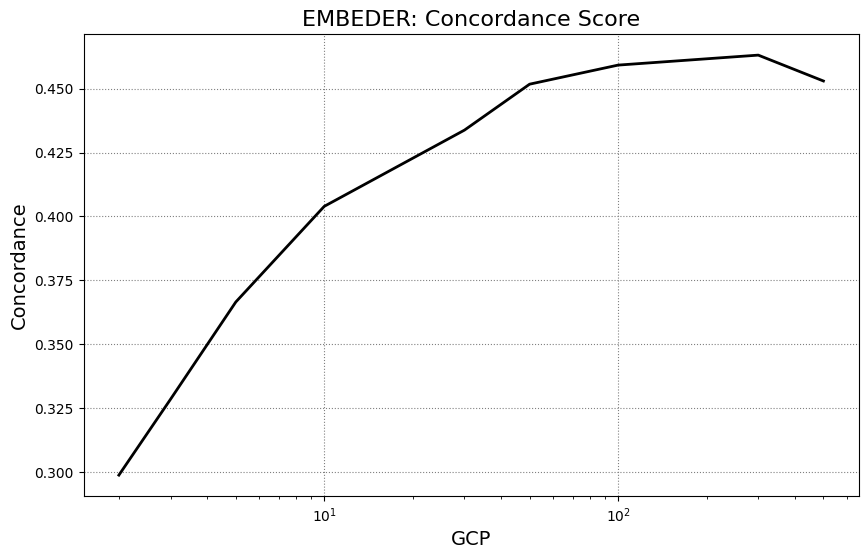

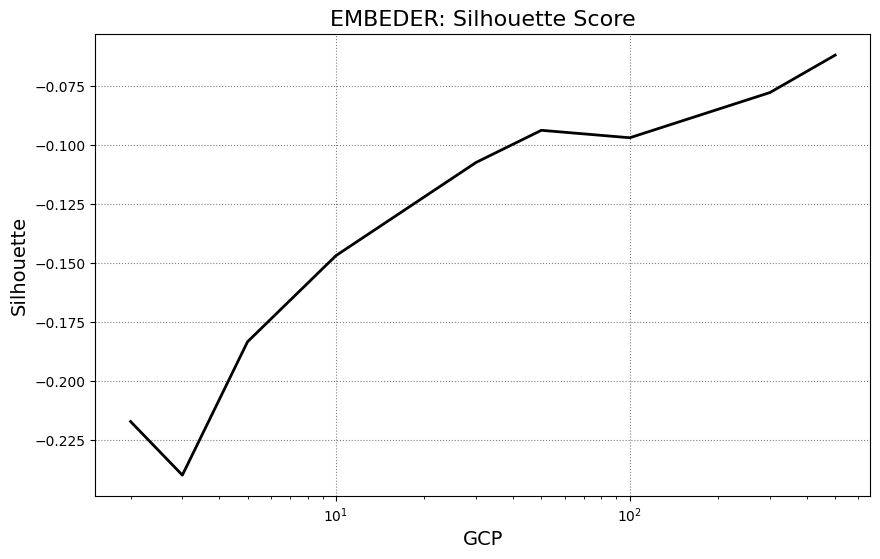

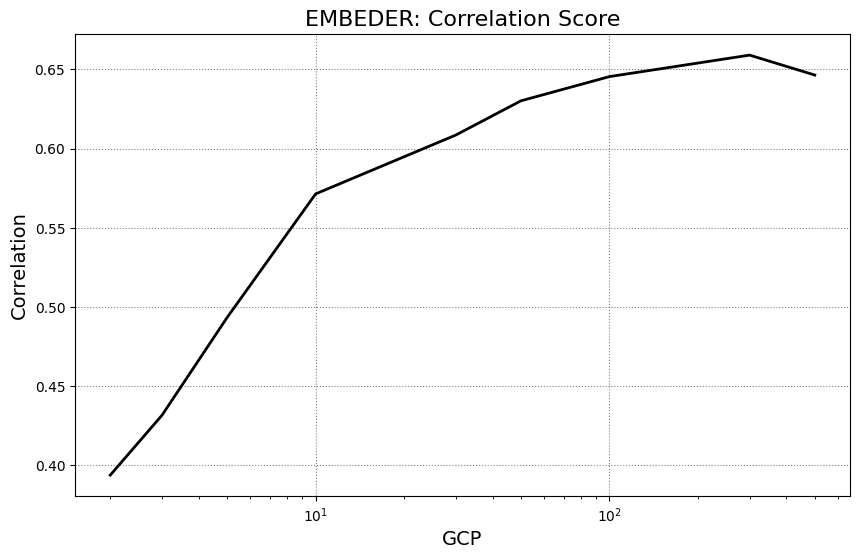

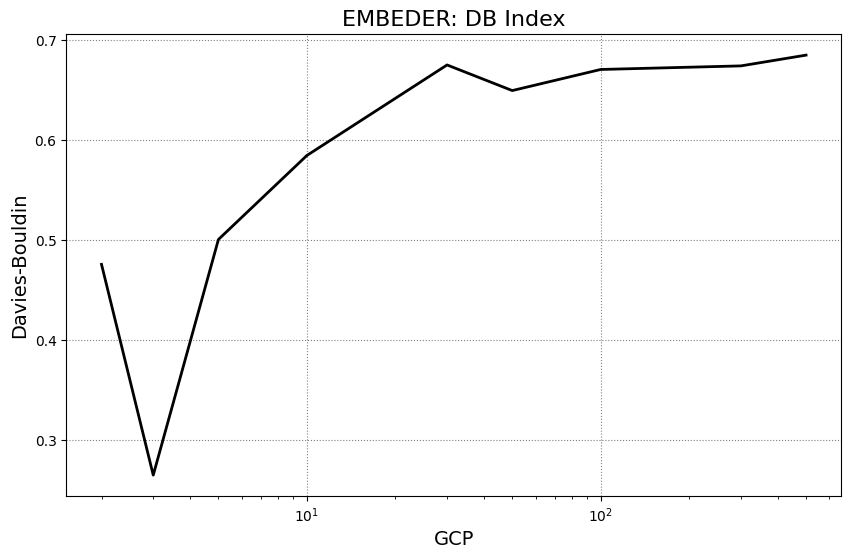

In [115]:
def plot_improved(x, y, ylab, main_title):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'k-', linewidth=2)
    plt.xscale('log')
    plt.xlabel('GCP', fontsize=14)
    plt.ylabel(ylab, fontsize=14)
    plt.title(main_title, fontsize=16)
    plt.grid(True, linestyle='dotted', color='gray')
    plt.box(True)
    plt.show()

# Plot the different metrics
plot_improved(GCP, knn_s, ylab="KNN", main_title="EMBEDER: KNN Score")
plot_improved(GCP, stab_s, ylab="Stability", main_title="EMBEDER: Stability Score")
plot_improved(GCP, concord_s, ylab="Concordance", main_title="EMBEDER: Concordance Score")
plot_improved(GCP, sil_s, ylab="Silhouette", main_title="EMBEDER: Silhouette Score")
plot_improved(GCP, cor_s, ylab="Correlation", main_title="EMBEDER: Correlation Score")
plot_improved(GCP, db_s, ylab="Davies-Bouldin", main_title="EMBEDER: DB Index")

# Deleting unstable points

In [119]:
# Load the data for perplexity = 30
GCP = 30
filename = f"EMBEDR_project_tsne_random_p{GCP}_pc2_knnMat_Y.pkl"
with open(filename, 'rb') as f:
    data = pickle.load(f)

knn_mat = data['knn_mat']  # List of DataFrames, each containing k-NN indices
Y_mat = data['Y_mat']  # List of embedded DataFrames (Y matrices) for each iteration

# Assuming `data_denoise` and `cls` are already loaded
n_samples = knn_mat[0].shape[0]

Indices not to keep for counting value 0.04: [   4   22   56   66   91   98  104  114  116  122  144  169  204  223
  242  256  292  348  446  453  460  480  484  496  529  598  603  606
  608  616  658  664  731  755  779  824  840  851  871  911  965  973
  993 1020 1053 1057 1105 1116 1134 1142 1147 1212 1219 1258 1301 1345
 1359 1364 1369 1372 1373 1414 1429 1460 1469 1505 1529 1545 1546 1569
 1592 1609 1659 1668 1687 1698 1731 1733 1745 1749 1759 1778 1794 1804
 1843 1877 1903 1940 1954 1972 2153 2154 2155 2217 2229 2248 2257 2266
 2272 2295 2323 2371 2405 2422 2426 2427 2439 2468 2470 2483 2491 2514
 2527 2528 2542 2569 2584 2588 2603 2622 2624 2654 2699 2712 2722 2737
 2740 2798 2800 2802 2806 2874 2881 2889 2926 2956 2962 3022 3096 3124
 3257 3286 3324 3351 3402]


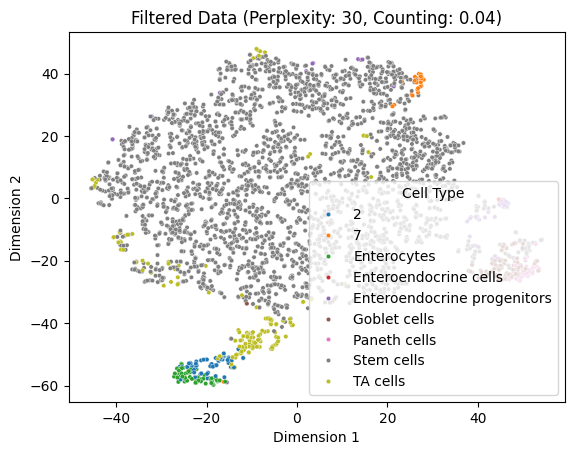

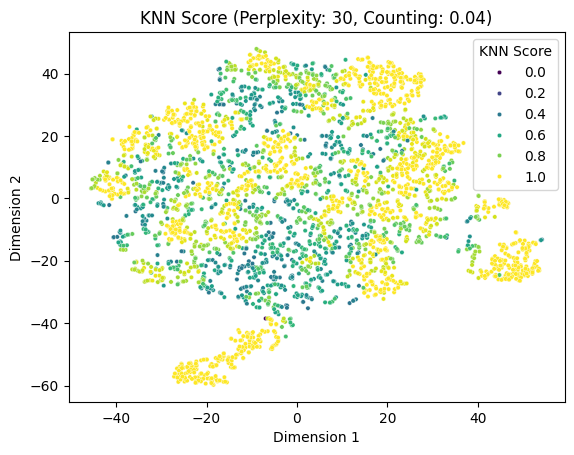

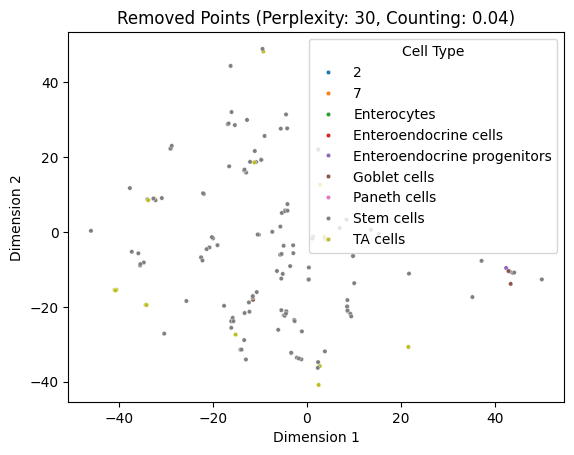

Count Table for Removed Data (Counting Value 0.04): cell_type
Stem cells                     126
TA cells                        15
Goblet cells                     3
Enteroendocrine progenitors      1
2                                0
7                                0
Enterocytes                      0
Enteroendocrine cells            0
Paneth cells                     0
Name: count, dtype: int64
Indices not to keep for counting value 0.08: [   4   22   51   56   66   77   83   91   95   98  104  114  116  122
  142  144  147  167  169  192  204  223  242  246  256  292  348  394
  446  451  453  460  480  484  495  496  521  525  527  529  553  556
  559  598  603  606  608  616  654  658  664  731  740  746  755  756
  764  765  779  824  838  840  851  869  871  880  896  911  913  916
  931  965  973  993 1020 1031 1053 1054 1057 1070 1086 1102 1105 1115
 1116 1123 1125 1127 1129 1134 1142 1146 1147 1155 1161 1167 1175 1199
 1203 1205 1212 1219 1220 1221 1229 1250 1255 1258 1259

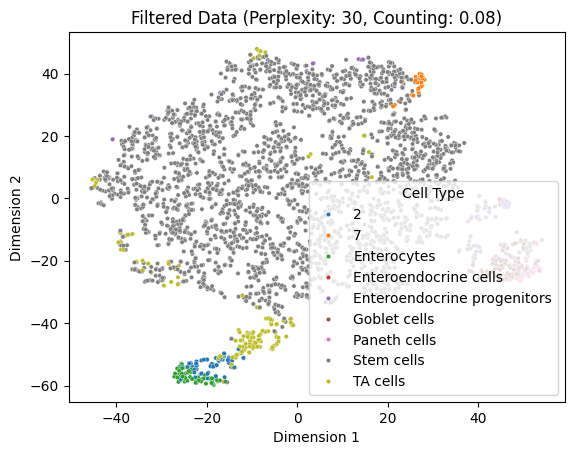

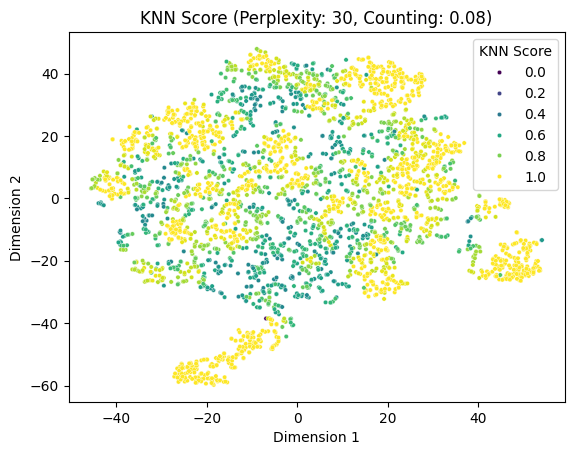

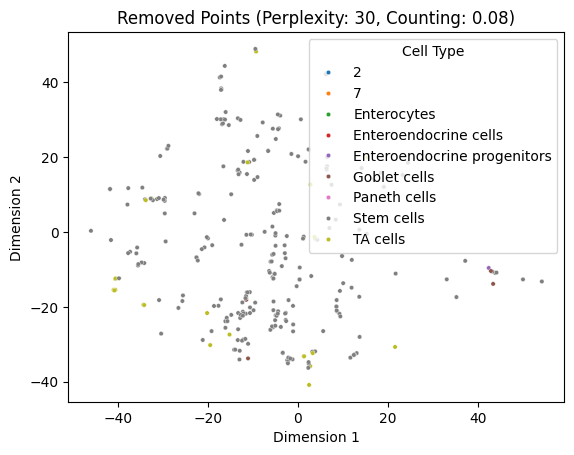

Count Table for Removed Data (Counting Value 0.08): cell_type
Stem cells                     254
TA cells                        23
Goblet cells                     4
Enteroendocrine progenitors      1
2                                0
7                                0
Enterocytes                      0
Enteroendocrine cells            0
Paneth cells                     0
Name: count, dtype: int64
Indices not to keep for counting value 0.12: [   4    5   22   51   52   56   59   66   77   83   91   95   98  104
  111  114  116  122  132  142  144  147  154  165  167  169  191  192
  196  201  202  204  217  223  242  246  256  275  277  292  348  353
  369  390  394  446  451  453  460  473  480  484  495  496  498  521
  525  527  529  553  556  559  573  598  603  606  607  608  612  614
  616  654  658  662  664  667  671  679  684  692  709  724  731  740
  746  755  756  764  765  779  817  824  832  838  840  851  861  863
  866  869  870  871  874  880  889  896  911  912  913

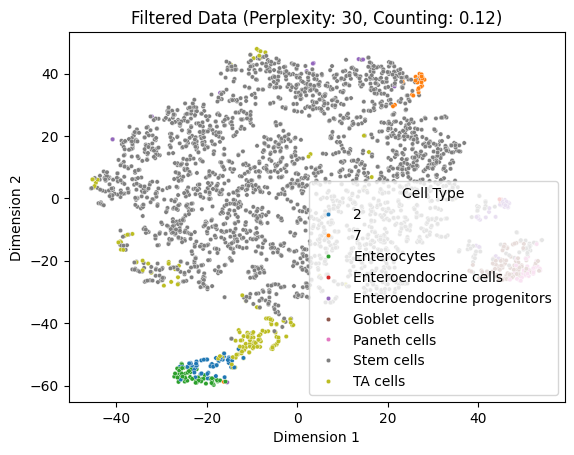

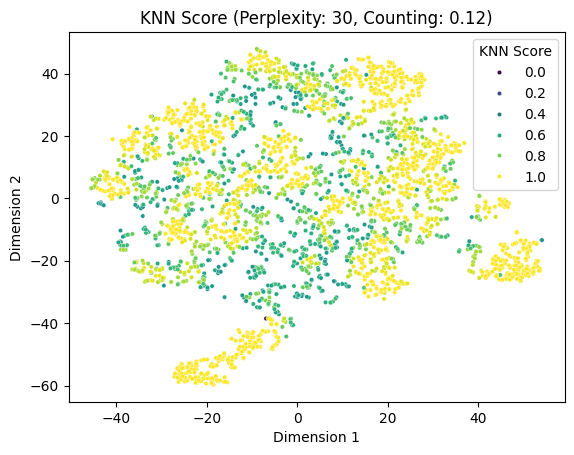

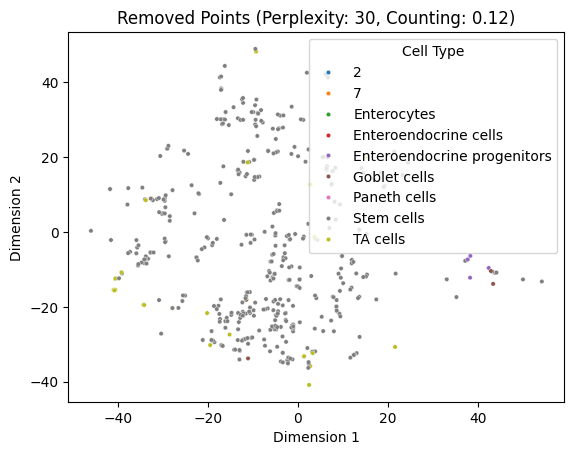

Count Table for Removed Data (Counting Value 0.12): cell_type
Stem cells                     408
TA cells                        25
Enteroendocrine progenitors      4
Goblet cells                     4
2                                0
7                                0
Enterocytes                      0
Enteroendocrine cells            0
Paneth cells                     0
Name: count, dtype: int64
Indices not to keep for counting value 0.16: [   4    5   17   22   29   32   38   40   47   51   52   56   59   66
   77   83   91   95   98  102  103  104  111  114  116  122  132  142
  144  147  154  165  167  169  191  192  196  201  202  203  204  217
  223  224  242  246  251  256  273  275  277  287  292  318  348  353
  365  369  379  388  390  394  400  412  428  446  448  451  453  460
  473  480  484  486  491  495  496  498  521  523  525  527  529  531
  539  547  553  555  556  559  573  580  598  603  606  607  608  612
  614  616  622  654  656  658  662  664  667  671  679

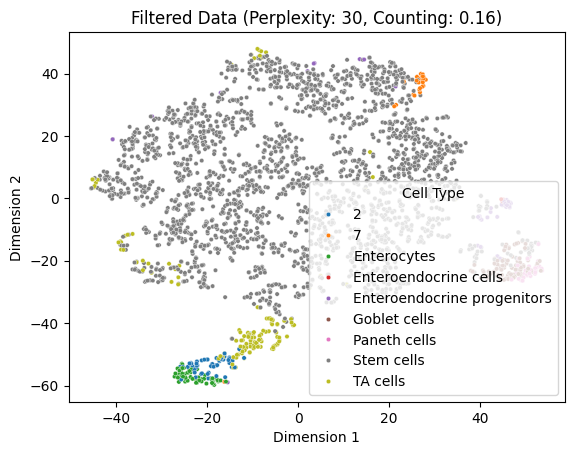

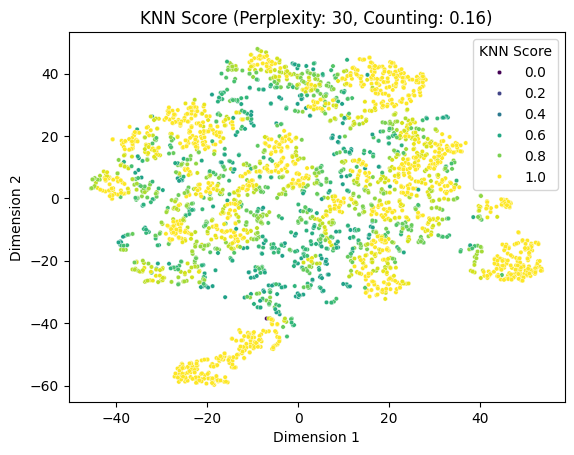

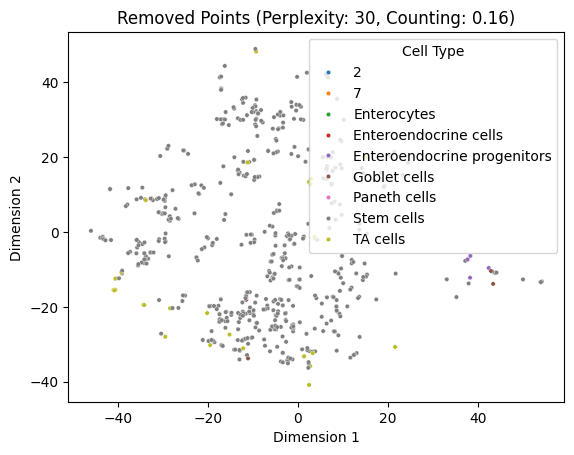

Count Table for Removed Data (Counting Value 0.16): cell_type
Stem cells                     515
TA cells                        32
Goblet cells                     5
Enteroendocrine progenitors      4
2                                0
7                                0
Enterocytes                      0
Enteroendocrine cells            0
Paneth cells                     0
Name: count, dtype: int64
KNN Stability Scores: [0.8357096058865033, 0.8537066246056783, 0.8732536255950405, 0.8867201887661141]
Stability Scores: [0.3975111111111111, 0.20044444444444448, 0.20227777777777778, 0.2034277777777778]
Concordance Scores: [0.4527547626247354, 0.4653596214511041, 0.4799269345732315, 0.49080801104972377]
Silhouette Scores: [-0.10789391488556183, -0.10579154927433845, -0.10789453584290382, -0.1071016394601224]
Davies-Bouldin Scores: [0.6836170117727016, 0.6792415459219299, 0.6731790406709474, 0.6794026408214141]
Purity Scores: [0.02033391575697556, 0.02607472265277183, 0.026849840999743673, 

In [121]:

N = 30  # Number of iterations
k = 50
counting_values = [0.04, 0.08, 0.12, 0.16]  # Adjust for your data

# Load the data for perplexity = 30
filename = f"EMBEDR_project_tsne_random_p{GCP}_pc2_knnMat_Y.pkl"
with open(filename, 'rb') as f:
    data = pickle.load(f)

knn_mat = data['knn_mat']  # List of DataFrames, each containing k-NN indices
Y_mat = data['Y_mat']  # List of embedded DataFrames (Y matrices) for each iteration

# Assuming `data_denoise` and `cls` are already loaded
n_samples = knn_mat[0].shape[0]

# Define lists to store results
knn_s = []
stab_s = []
concord_s = []
sil_s = []
db_s = []
npurity_s = []
indices_not_to_keep_list = []

for counting in range(4):
    counting_numb = counting_values[counting]

    # Step 1: Construct k-NN graph
    knn_graph = np.zeros((n_samples, n_samples))
    for knn_df in knn_mat:
        for j in range(n_samples):
            neighbors = knn_df.iloc[j, :].values
            knn_graph[j, neighbors] += 1

    knn_graph = np.maximum(knn_graph, knn_graph.T)  # Ensure symmetry

    # Step 2: Calculate k-NN score for each point
    knn_score = []
    for i in range(n_samples):
        non_zero_indices = knn_graph[i, :] != 0
        score = np.quantile(knn_graph[i, non_zero_indices] / N, 0.75)
        knn_score.append(score)

    # Step 3: Threshold to determine points to keep or remove
    threshold = np.quantile(knn_score, counting_numb)
    indices_to_keep = np.where(np.array(knn_score) > threshold)[0]
    indices_not_to_keep = np.where(np.array(knn_score) <= threshold)[0]
    indices_not_to_keep_list.append(indices_not_to_keep)

    print(f"Indices not to keep for counting value {counting_numb}: {indices_not_to_keep}")

    # Step 4: Filter data based on indices to keep
    new_Y = Y_mat[-1].iloc[indices_to_keep, :].values  # Using the last iteration's Y as an example
    filtered_knn_score = np.array(knn_score)[indices_to_keep]  # Filter knn_score based on indices to keep
    filtered_df = data_denoise[indices_to_keep, :]
    filtered_cls = cls[indices_to_keep]

    # Filter knn_mat based on indices to keep
    new_knn_mat = [knn.iloc[indices_to_keep, :] for knn in knn_mat]

    # Step 5: Plotting
    plot_data = pd.DataFrame({
        'Dimension 1': new_Y[:, 0],
        'Dimension 2': new_Y[:, 1],
        'Cell Type': filtered_cls
    })
    plt.figure()
    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cell Type', data=plot_data, s=10)
    plt.title(f"Filtered Data (Perplexity: {GCP}, Counting: {counting_numb})")
    plt.show()

    # Plot knn_score
    plot_data_knn = pd.DataFrame({
        'Dimension 1': new_Y[:, 0],
        'Dimension 2': new_Y[:, 1],
        'KNN Score': filtered_knn_score  # Use filtered knn_score to match new_Y
    })
    plot_data_knn.iloc[0, 2] = 0  # Adjust as per original code logic
    plot_data_knn.iloc[1, 2] = 1
    plt.figure()
    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='KNN Score', data=plot_data_knn, s=10, palette='viridis')
    plt.title(f"KNN Score (Perplexity: {GCP}, Counting: {counting_numb})")
    plt.show()

    # Plot removed points
    new_Y2 = Y_mat[-1].iloc[indices_not_to_keep, :].values
    filtered_cls2 = cls[indices_not_to_keep]
    plot_data_removed = pd.DataFrame({
        'Dimension 1': new_Y2[:, 0],
        'Dimension 2': new_Y2[:, 1],
        'Cell Type': filtered_cls2
    })
    plt.figure()
    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cell Type', data=plot_data_removed, s=10)
    plt.title(f"Removed Points (Perplexity: {GCP}, Counting: {counting_numb})")
    plt.show()

    # Count cell types in removed data
    count_table = pd.Series(filtered_cls2).value_counts()
    print(f"Count Table for Removed Data (Counting Value {counting_numb}):", count_table)

    # Step 6: Calculate stability scores for different iterations
    temp_out = np.zeros((N, N))
    for i in range(N - 1):
        for j in range(i + 1, N):
            temp = []
            for mn in range(len(new_knn_mat[0])):
                intersection = len(set(new_knn_mat[i].iloc[mn, :k]).intersection(set(new_knn_mat[j].iloc[mn, :k])))
                temp.append(intersection / k)
            temp_out[i, j] = np.median(temp)

    stab_s.append(np.nanmean(temp_out))

    # Step 7: Calculate true concordance
    k = 100
    nbrs_high = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(filtered_df)
    _, knn_h = nbrs_high.kneighbors(filtered_df)

    nbrs_low = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(new_Y)
    _, knn_l = nbrs_low.kneighbors(new_Y)

    concord_score = []
    for i in range(knn_h.shape[0]):
        concord = len(set(knn_h[i, :]).intersection(set(knn_l[i, :]))) / k
        concord_score.append(concord)

    concord_s.append(np.mean(concord_score))

    # Step 8: Calculate silhouette score
    sil_scores = silhouette_samples(new_Y, filtered_cls)
    sil_s.append(np.mean(sil_scores))

    # Step 9: Calculate Davies-Bouldin index
    db_s.append(1 / davies_bouldin_score(new_Y, filtered_cls))

    # Step 10: Calculate purity score for the lowest 5 percent of data
    npurity_scores = np.random.rand(len(new_Y))  # Placeholder for purity calculation
    sorted_purity = np.sort(npurity_scores)
    lower_5_percent_count = int(0.05 * len(sorted_purity))
    lower_5_percent_purity = sorted_purity[:lower_5_percent_count]
    npurity_s.append(np.mean(lower_5_percent_purity))

    # Update knn_s with the mean k-NN score
    knn_s.append(np.mean(filtered_knn_score))

# Output the final scores
print("KNN Stability Scores:", knn_s)
print("Stability Scores:", stab_s)
print("Concordance Scores:", concord_s)
print("Silhouette Scores:", sil_s)
print("Davies-Bouldin Scores:", db_s)
print("Purity Scores:", npurity_s)



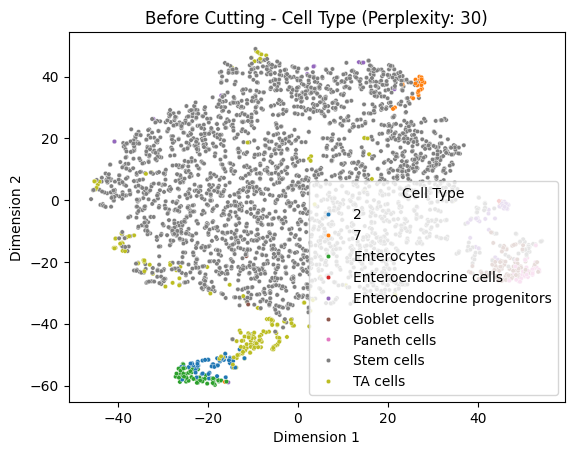

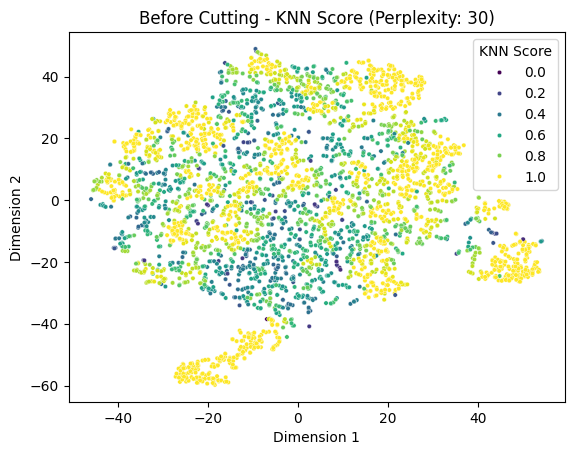

KNN Stability Score Before Cutting: 0.8127510621861723
Stability Score Before Cutting: 0.3941555555555556
Concordance Score Before Cutting: 0.43732039397450756
Silhouette Score Before Cutting: -0.1087908626302768
Davies-Bouldin Score Before Cutting: 0.6782820090629863
Purity Score Before Cutting: 0.02723218804140689


In [124]:
# Load the data for perplexity = 30
filename = f"EMBEDR_project_tsne_random_p{GCP}_pc2_knnMat_Y.pkl"
with open(filename, 'rb') as f:
    data = pickle.load(f)

knn_mat = data['knn_mat']  # List of DataFrames, each containing k-NN indices
Y_mat = data['Y_mat']  # List of embedded DataFrames (Y matrices) for each iteration

n_samples = knn_mat[0].shape[0]

# Step 1: Construct k-NN graph before cutting threshold
knn_graph = np.zeros((n_samples, n_samples))
for knn_df in knn_mat:
    for j in range(n_samples):
        neighbors = knn_df.iloc[j, :].values
        knn_graph[j, neighbors] += 1

knn_graph = np.maximum(knn_graph, knn_graph.T)  # Ensure symmetry

# Step 2: Calculate k-NN score for each point
knn_score = []
for i in range(n_samples):
    non_zero_indices = knn_graph[i, :] != 0
    score = np.quantile(knn_graph[i, non_zero_indices] / N, 0.75)
    knn_score.append(score)

# Step 3: Plotting before threshold cutting
plot_data = pd.DataFrame({
    'Dimension 1': Y_mat[-1]['Dimension 1'],
    'Dimension 2': Y_mat[-1]['Dimension 2'],
    'Cell Type': cls
})
plt.figure()
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cell Type', data=plot_data, s=10)
plt.title(f"Before Cutting - Cell Type (Perplexity: {GCP})")
plt.show()

# Plotting knn_score before threshold cutting
plot_data_knn = pd.DataFrame({
    'Dimension 1': Y_mat[-1]['Dimension 1'],
    'Dimension 2': Y_mat[-1]['Dimension 2'],
    'KNN Score': knn_score
})
plot_data_knn.iloc[0, 2] = 0  # Adjust as per original code logic
plot_data_knn.iloc[1, 2] = 1
plt.figure()
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='KNN Score', data=plot_data_knn, s=10, palette='viridis')
plt.title(f"Before Cutting - KNN Score (Perplexity: {GCP})")
plt.show()

# Step 4: Calculate metrics before threshold cutting
# Calculate k-NN stability score
knn_s_before = np.mean(knn_score)

# Calculate stability score for different iterations
temp_out = np.zeros((N, N))
for i in range(N - 1):
    for j in range(i + 1, N):
        temp = []
        for mn in range(n_samples):
            intersection = len(set(knn_mat[i].iloc[mn, :k]).intersection(set(knn_mat[j].iloc[mn, :k])))
            temp.append(intersection / k)
        temp_out[i, j] = np.median(temp)

stab_s_before = np.nanmean(temp_out)

# Calculate true concordance between high and low dimensional data
k = 100
nbrs_high = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(data_denoise)
_, knn_h = nbrs_high.kneighbors(data_denoise)

nbrs_low = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(Y_mat[-1].values)
_, knn_l = nbrs_low.kneighbors(Y_mat[-1].values)

concord_score = []
for i in range(knn_h.shape[0]):
    concord = len(set(knn_h[i, :]).intersection(set(knn_l[i, :]))) / k
    concord_score.append(concord)

concord_s_before = np.mean(concord_score)

# Calculate silhouette score
sil_scores = silhouette_samples(Y_mat[-1].values, cls)
sil_s_before = np.mean(sil_scores)

# Calculate Davies-Bouldin index
db_s_before = 1 / davies_bouldin_score(Y_mat[-1].values, cls)

# Placeholder for purity calculation (neighborPurity function is not available)
npurity_scores = np.random.rand(len(Y_mat[-1]))  # Placeholder for purity calculation
sorted_purity = np.sort(npurity_scores)
lower_5_percent_count = int(0.05 * len(sorted_purity))
lower_5_percent_purity = sorted_purity[:lower_5_percent_count]
npurity_s_before = np.mean(lower_5_percent_purity)

# Print metrics before threshold cutting
print("KNN Stability Score Before Cutting:", knn_s_before)
print("Stability Score Before Cutting:", stab_s_before)
print("Concordance Score Before Cutting:", concord_s_before)
print("Silhouette Score Before Cutting:", sil_s_before)
print("Davies-Bouldin Score Before Cutting:", db_s_before)
print("Purity Score Before Cutting:", npurity_s_before)


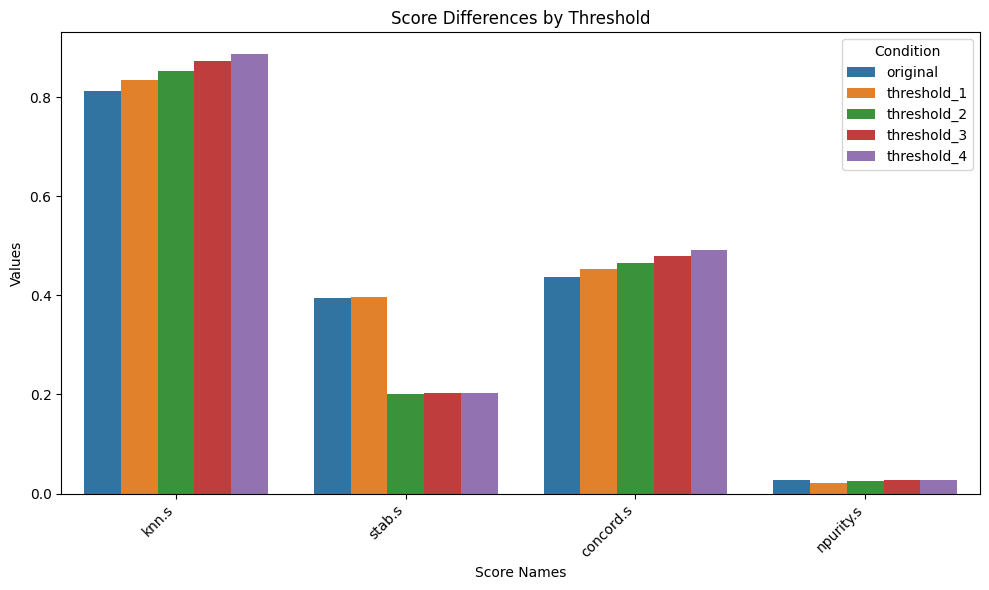

In [125]:
# differences

# Define the score data
threshold_1 = [knn_s[0], stab_s[0], concord_s[0], npurity_s[0]]
threshold_2 = [knn_s[1], stab_s[1], concord_s[1], npurity_s[1]]
threshold_3 = [knn_s[2], stab_s[2], concord_s[2], npurity_s[2]]
threshold_4 = [knn_s[3], stab_s[3], concord_s[3], npurity_s[3]]
original = [knn_s_before, stab_s_before, concord_s_before, npurity_s_before]

names = ["knn.s", "stab.s", "concord.s", "npurity.s"]

# Create a DataFrame for comparison
comparison = pd.DataFrame({
    'names': names,
    'original': original,
    'threshold_1': threshold_1,
    'threshold_2': threshold_2,
    'threshold_3': threshold_3,
    'threshold_4': threshold_4
})

# Reshape the DataFrame to long format for plotting
comparison_long = comparison.melt(id_vars="names", var_name="condition", value_name="value")

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x="names", y="value", hue="condition", data=comparison_long, dodge=True)

# Customize the plot
plt.xlabel("Score Names")
plt.ylabel("Values")
plt.title("Score Differences by Threshold")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Condition")
plt.tight_layout()

# Show the plot
plt.show()


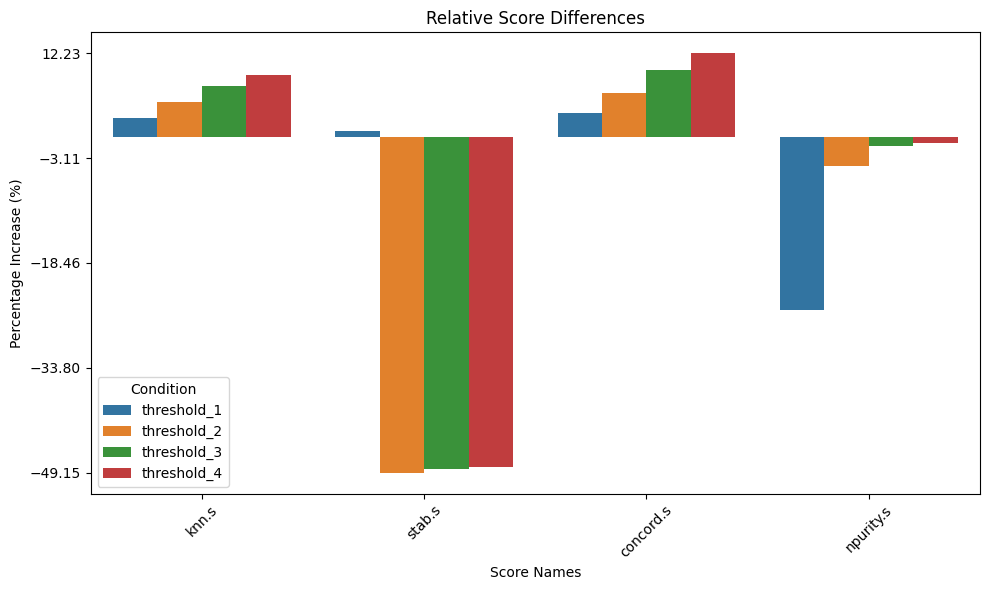

In [126]:
#relative differences

# Data
comparison = pd.DataFrame({
    'names': ["knn.s", "stab.s", "concord.s", "npurity.s"],
    'original': original,
    'threshold_1': threshold_1,
    'threshold_2': threshold_2,
    'threshold_3': threshold_3,
    'threshold_4': threshold_4
})

# Calculate percentage increase for each threshold
for col in comparison.columns[2:]:
    comparison[col] = (comparison[col] - comparison['original']) / comparison['original'] * 100

# Handle negative or zero original values
comparison.loc[comparison['original'] <= 0, comparison.columns[2:]] *= -1

# Drop the 'original' column
comparison = comparison.drop(columns=['original'])

# Melt the data frame for plotting
comparison_long = pd.melt(comparison, id_vars=['names'], var_name='Condition', value_name='Percentage Increase')

# Determine dynamic range for y-axis
min_val = comparison_long['Percentage Increase'].min()
max_val = comparison_long['Percentage Increase'].max()
breaks = np.linspace(min_val, max_val, num=5)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='names', y='Percentage Increase', hue='Condition', data=comparison_long, dodge=True)
plt.xlabel('Score Names')
plt.ylabel('Percentage Increase (%)')
plt.xticks(rotation=45)
plt.yticks(breaks)
plt.title('Relative Score Differences')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()


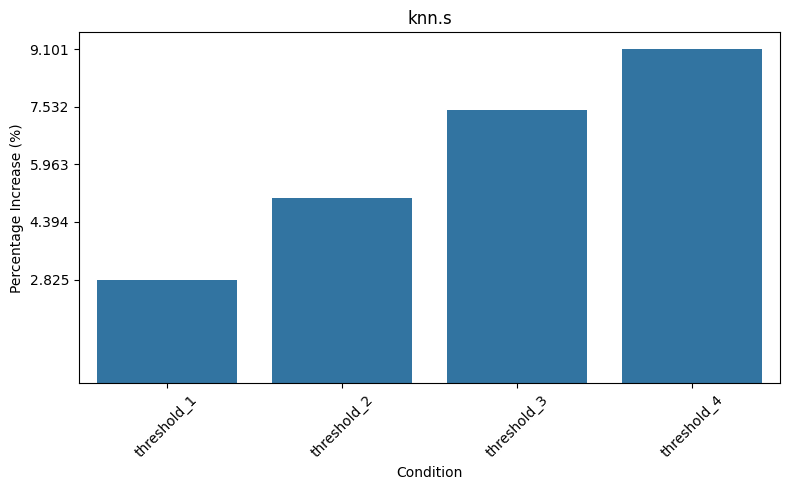

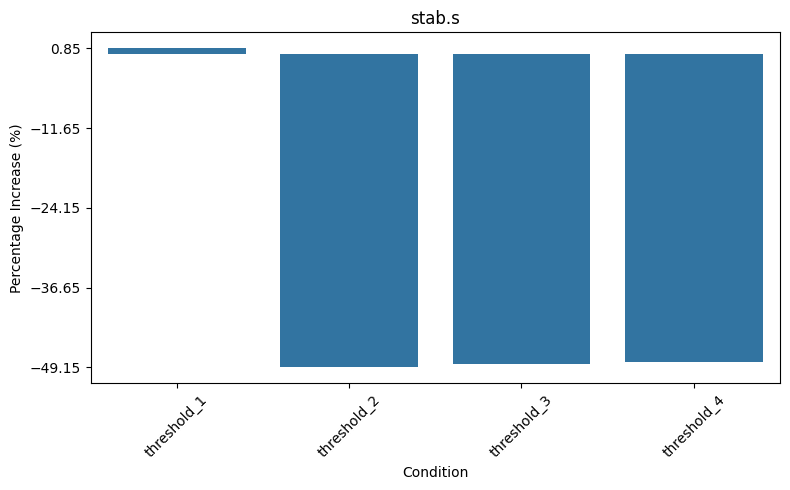

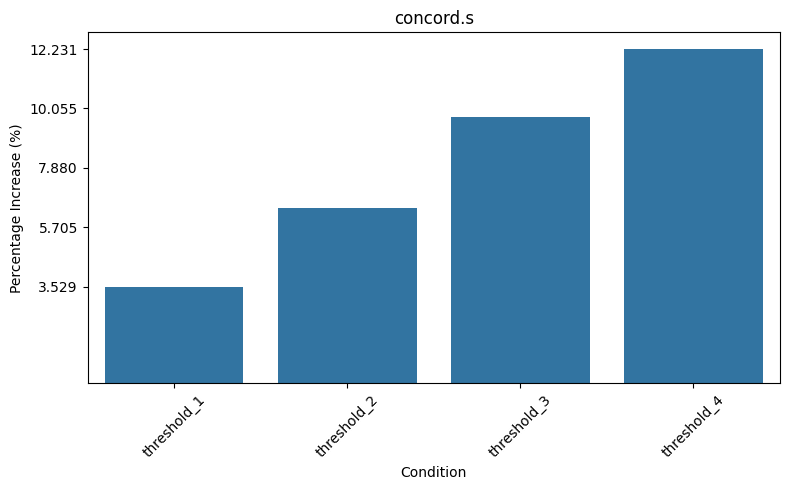

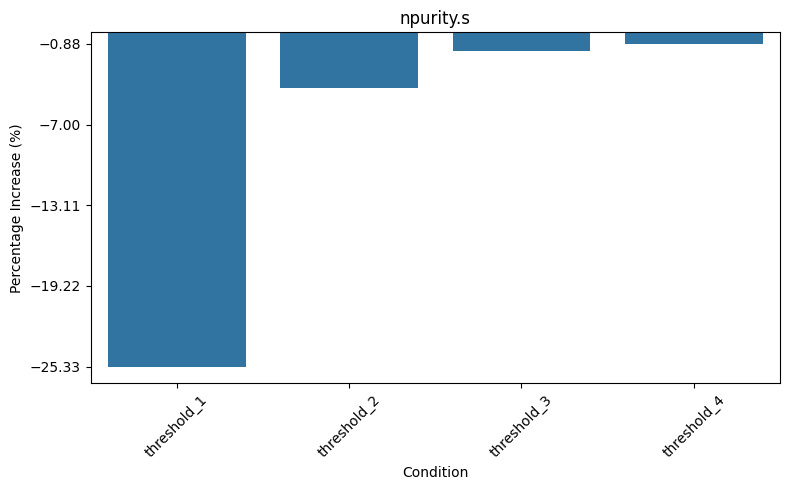

In [127]:
# Data
comparison = pd.DataFrame({
    'names': ["knn.s", "stab.s", "concord.s", "npurity.s"],
    'original': original,
    'threshold_1': threshold_1,
    'threshold_2': threshold_2,
    'threshold_3': threshold_3,
    'threshold_4': threshold_4
})

# Calculate percentage increase for each threshold
for col in comparison.columns[2:]:
    comparison[col] = (comparison[col] - comparison['original']) / comparison['original'] * 100

# Handle negative or zero original values
comparison.loc[comparison['original'] <= 0, comparison.columns[2:]] *= -1

# Drop the 'original' column
comparison = comparison.drop(columns=['original'])

# Melt the data frame for plotting
comparison_long = pd.melt(comparison, id_vars=['names'], var_name='Condition', value_name='Percentage Increase')

# Function to create and display individual plots
def create_plot(score_name):
    data_subset = comparison_long[comparison_long['names'] == score_name]
    
    # Determine y-axis limits specific to each plot
    min_val = data_subset['Percentage Increase'].min()
    max_val = data_subset['Percentage Increase'].max()
    breaks = np.linspace(min_val, max_val, num=5)
    
    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Condition', y='Percentage Increase', data=data_subset, dodge=True)
    plt.xlabel('Condition')
    plt.ylabel('Percentage Increase (%)')
    plt.xticks(rotation=45)
    plt.yticks(breaks)
    plt.title(score_name)
    plt.tight_layout()
    plt.show()

# Generate and print each plot separately
create_plot("knn.s")
create_plot("stab.s")
create_plot("concord.s")
create_plot("npurity.s")


# further analysis by calculating EES score (Using existing t-SNE result)

In [4]:
# Load your new dataset
data = pd.read_csv("embryoid_body.csv", dtype=str)  # update with your new dataset path
cell_type = pd.read_csv("embryoid_body_cls.csv", dtype=str)  # update with your new dataset cell type path

# Ensure index is of type string
data.index = data.index.astype(str)
cell_type.index = cell_type.index.astype(str)

# Drop unnecessary columns and align data
data = data.drop(data.columns[0], axis=1)
cell_type = cell_type.drop(cell_type.columns[0], axis=1)

In [5]:
#embryoid body data only
data = pd.read_csv("embryoid_body.csv", dtype=str)  # update with your new dataset path

cell_type = data['cell_type'].astype('category')  # update with your new dataset cell type path

data = data.iloc[:, 8:].to_numpy().T

cell_type.index = cell_type.index.astype(str)

In [8]:
Y = pd.read_csv("embryoid_body_umap_lvrandom_p2000_pc5_Y_matrix.csv", dtype=str)
Y.index = Y.index.astype(str)
Y = Y.drop(Y.columns[0], axis=1)
Y = Y.apply(pd.to_numeric)

print(Y)

array_Y = Y.to_numpy(dtype='float32')
print(array_Y)

             V1        V2
0     -6.511627  5.409598
1     -5.837244  4.228592
2     -3.949526  4.593604
3     -4.099818  4.151329
4     -2.937120  3.420073
...         ...       ...
31024 -0.003416  3.710524
31025  4.750318 -4.851681
31026  1.018962 -4.049842
31027  0.934358 -3.991032
31028  2.910289 -1.947490

[31029 rows x 2 columns]
[[-6.511627    5.4095984 ]
 [-5.837244    4.2285924 ]
 [-3.9495263   4.5936036 ]
 ...
 [ 1.0189615  -4.0498424 ]
 [ 0.93435776 -3.9910321 ]
 [ 2.9102888  -1.9474905 ]]


In [9]:
embedr_obj = EMBEDR(perplexity=2000, random_state=1, verbose=1, project_dir='./')

In [10]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix
import numpy as np

# Step 1: Fit kNN Model to Find Neighbors
n_neighbors = 50  # Number of nearest neighbors to consider

# Fit the kNN model on the 2D embedding array
knn_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(array_Y)

# Find the nearest neighbors (distances and indices of the 50 nearest neighbors for each point)
distances, indices = knn_model.kneighbors(array_Y)

# Step 2: Construct the Affinity Matrix Using kNN
n_samples = array_Y.shape[0]
affinity_matrix = lil_matrix((n_samples, n_samples))

# Populate the affinity matrix using the neighbors
for i in range(n_samples):
    for j in range(n_neighbors):
        neighbor_idx = indices[i][j]
        distance = distances[i][j]
        
        # Assign an affinity value using Gaussian kernel (weighted affinity)
        affinity_value = np.exp(-distance ** 2 / (2 * np.mean(distances) ** 2))  # Gaussian weighting (optional)
        
        # Alternatively, you can use binary affinity
        # affinity_value = 1  # Uncomment this for binary affinity (just indicating neighbors)

        affinity_matrix[i, neighbor_idx] = affinity_value

# Convert to CSR format for efficient computation later
affinity_matrix = affinity_matrix.tocsr()

# Print a summary of the affinity matrix
print(affinity_matrix)


  (0, 0)	1.0
  (0, 9)	0.7685903528975477
  (0, 14)	0.6900932651477346
  (0, 189)	0.7462642256605977
  (0, 312)	0.9263502185789017
  (0, 531)	0.9636422372419434
  (0, 588)	0.9746253555979592
  (0, 686)	0.6926496409565369
  (0, 794)	0.761717831917388
  (0, 880)	0.7426271672302563
  (0, 886)	0.9410514287658198
  (0, 968)	0.9085174351890642
  (0, 1001)	0.9924546220878028
  (0, 1139)	0.9231634429984823
  (0, 1199)	0.7578517216837445
  (0, 1264)	0.6644900621810084
  (0, 1448)	0.7949605050207919
  (0, 1462)	0.9457381097261645
  (0, 1477)	0.9043603523254444
  (0, 1488)	0.96145083260099
  (0, 1547)	0.7733451219068717
  (0, 1644)	0.6942082680986976
  (0, 1807)	0.8460793428158283
  (0, 1830)	0.691802959314282
  (0, 2157)	0.6059378105321047
  :	:
  (31028, 26682)	0.4884950916415083
  (31028, 26887)	0.6822141046572919
  (31028, 26909)	0.9302063154277845
  (31028, 26971)	0.2826083178915849
  (31028, 26990)	0.24000322668626248
  (31028, 27095)	0.3021567356175109
  (31028, 27337)	0.9737602699449529
  

In [11]:
# Assuming `embedr_obj` is already created, and you have assigned your existing Y embedding:
embedr_obj.data_Y = array_Y  # Assigning the 2D embedding to `embedr_obj`

# Use the generated affinity matrix
P = affinity_matrix  # This is your kNN-based affinity matrix

# Calculate Embedding Evaluation Scores (EES) using the affinity matrix and embeddings
ees_scores = embedr_obj.calculate_EES(P, embedr_obj.data_Y)

# Print the point-wise EES scores
print(ees_scores)


[[0.00978727 0.02142736 0.02949391 ... 0.00483246 0.00436091 0.1852811 ]]


In [12]:
ees_scores = ees_scores.flatten() 

EMBEDER vs Entropy

In [13]:
print(ees_scores)
len(ees_scores)

[0.00978727 0.02142736 0.02949391 ... 0.00483246 0.00436091 0.1852811 ]


31029

In [47]:
# Create a DataFrame
df = pd.DataFrame(ees_scores, columns=['Scores'])

# Add an original index column to keep track of original positions
df['Original_Index'] = df.index

# Sort the DataFrame by scores to find the lowest 10%
sorted_df = df.sort_values(by='Scores', ascending=True)


# Calculate EES score and make boxplot: deleting points with smaller EES score

In [150]:
# Determine the cutoff value at the 10% position
cutoff_2 = sorted_df.iloc[int(len(df) * 0.02 - 1)]['Scores'] 
print("Cutoff value for the lowest 2%:", cutoff_2)

cutoff_8 = sorted_df.iloc[int(len(df) * 0.08 - 1)]['Scores'] 
print("Cutoff value for the lowest 8%:", cutoff_8)

cutoff_15 = sorted_df.iloc[int(len(df) * 0.15 - 1)]['Scores'] 
print("Cutoff value for the lowest 15%:", cutoff_15)

Cutoff value for the lowest 2%: 6.453122273519796e-05
Cutoff value for the lowest 8%: 7.606412041738508e-05
Cutoff value for the lowest 15%: 0.0001156512067659321


In [151]:
# Get the original indices of the lowest n%

lowest_2 = sorted_df.head(int(len(df) * 0.02))['Original_Index'].tolist()
print("Original indices of the lowest 10%:", lowest_2)


lowest_10 = sorted_df.head(int(len(df) * 0.08))['Original_Index'].tolist()
print("Original indices of the lowest 10%:", lowest_10)

lowest_20 = sorted_df.head(int(len(df) * 0.15))['Original_Index'].tolist()
print("Original indices of the lowest 20%:", lowest_20)

Original indices of the lowest 10%: [898, 962, 954, 1001, 1023, 867, 530, 1067, 969, 1049, 1040, 885, 929, 1053, 983, 976, 968, 577, 909, 1075, 1038]
Original indices of the lowest 10%: [898, 962, 954, 1001, 1023, 867, 530, 1067, 969, 1049, 1040, 885, 929, 1053, 983, 976, 968, 577, 909, 1075, 1038, 1071, 852, 881, 1010, 1032, 986, 939, 863, 111, 1011, 917, 1013, 1077, 227, 1018, 1074, 1043, 1025, 1029, 995, 1042, 889, 982, 1009, 847, 879, 157, 936, 925, 970, 1069, 223, 1055, 1057, 902, 957, 942, 156, 859, 143, 1054, 927, 943, 192, 913, 1022, 883, 899, 1052, 864, 866, 940, 200, 1047, 921, 154, 632, 953, 903, 858, 907, 1044, 920, 911, 128]
Original indices of the lowest 20%: [898, 962, 954, 1001, 1023, 867, 530, 1067, 969, 1049, 1040, 885, 929, 1053, 983, 976, 968, 577, 909, 1075, 1038, 1071, 852, 881, 1010, 1032, 986, 939, 863, 111, 1011, 917, 1013, 1077, 227, 1018, 1074, 1043, 1025, 1029, 995, 1042, 889, 982, 1009, 847, 879, 157, 936, 925, 970, 1069, 223, 1055, 1057, 902, 957, 942, 156

In [153]:
# Creating DataFrames
df_lowest_2 = pd.DataFrame(lowest_2, columns=['x'])
df_lowest_10 = pd.DataFrame(lowest_10, columns=['x'])
df_lowest_20 = pd.DataFrame(lowest_20, columns=['x'])

# Define base file name (customize this as per your requirements)
base_filename = 'ipsc_EMBEDR'

# Saving DataFrames to CSV with proper formatting
df_lowest_2.to_csv(f'{base_filename}_2_p150_pc6.csv', index=True)
df_lowest_10.to_csv(f'{base_filename}_8_p150_pc6.csv', index=True)
df_lowest_20.to_csv(f'{base_filename}_15_p150_pc6.csv', index=True)

# EMBEDR vs Stability

In [69]:
data_name = "embryoid_body"  # Replace this with the actual data name used in your CSV filenames

# Read the CSV files into pandas DataFrames
unstable_4 = pd.read_csv(f'{data_name}_dynamicViz_global_stability_2_p2000_pc10.csv', index_col=0)
unstable_8 = pd.read_csv(f'{data_name}_dynamicViz_global_stability_10_p2000_pc10.csv', index_col=0)
unstable_12 = pd.read_csv(f'{data_name}_dynamicViz_global_stability_20_p2000_pc10.csv', index_col=0)
#unstable_16 = pd.read_csv(f'{data_name}_unstable_16_p30_pc6.csv', index_col=0)

In [71]:
# Extract the indices of unstable points
unstable_4_indices = unstable_4.index.astype(int)
unstable_8_indices = unstable_8.index.astype(int)
unstable_12_indices = unstable_12.index.astype(int)
#unstable_16_indices = unstable_16.index.astype(int)

# Find corresponding EES scores for each set of unstable points
unstable_4_ees_scores = ees_scores[unstable_4_indices]
unstable_8_ees_scores = ees_scores[unstable_8_indices]
unstable_12_ees_scores = ees_scores[unstable_12_indices]
#unstable_16_ees_scores = ees_scores[unstable_16_indices]

# Print or further analyze the EES scores of unstable points
print("EES Scores for unstable_4 points:", len(unstable_4_ees_scores))
print("EES Scores for unstable_8 points:", len(unstable_8_ees_scores))
print("EES Scores for unstable_12 points:", len(unstable_12_ees_scores))
#print("EES Scores for unstable_16 points:", len(unstable_16_ees_scores))


EES Scores for unstable_4 points: 1551
EES Scores for unstable_8 points: 4654
EES Scores for unstable_12 points: 7757


In [75]:
import numpy as np

# Assuming unstable_4_ees_scores, unstable_8_ees_scores, unstable_12_ees_scores, unstable_16_ees_scores are defined as Pandas Series or NumPy arrays

# Calculate the average EES score for each group
average_ees_4 = np.mean(unstable_4_ees_scores)
average_ees_8 = np.mean(unstable_8_ees_scores)
average_ees_12 = np.mean(unstable_12_ees_scores)
#average_ees_16 = np.mean(unstable_16_ees_scores)

# Print the average EES scores for each group
print("Average EES Score for unstable 4% points:", average_ees_4)
print("Average EES Score for unstable 8% points:", average_ees_8)
print("Average EES Score for unstable 12% points:", average_ees_12)
#print("Average EES Score for unstable 16% points:", average_ees_16)


Average EES Score for unstable 4% points: 0.09986555206440789
Average EES Score for unstable 8% points: 0.09663367710094489
Average EES Score for unstable 12% points: 0.10626779102867417


In [79]:
import numpy as np
from scipy import stats

# Convert EES values to numpy arrays if needed
unstable_4_ees_scores = np.array(unstable_4_ees_scores)
unstable_8_ees_scores = np.array(unstable_8_ees_scores)
unstable_12_ees_scores = np.array(unstable_12_ees_scores)
#unstable_16_ees_scores = np.array(unstable_16_ees_scores)
ALL_ees_scores = np.array(ees_scores)

# Function to perform t-test and compute 99% confidence interval
def perform_ttest(group1, group2, group1_name, group2_name):
    # Perform the two-sample t-test
    t_stat, p_value = stats.ttest_ind(group1, group2)
    
    # Calculate mean difference and standard error
    mean_diff = np.mean(group1) - np.mean(group2)
    std_err_1 = np.std(group1, ddof=1) / np.sqrt(len(group1))
    std_err_2 = np.std(group2, ddof=1) / np.sqrt(len(group2))
    std_err_diff = np.sqrt(std_err_1**2 + std_err_2**2)
    
    # Degrees of freedom
    df = len(group1) + len(group2) - 2
    
    # T-critical value for 99% confidence interval
    t_critical = stats.t.ppf(1 - 0.005, df)
    
    # Calculate 99% confidence interval
    ci_lower = mean_diff - t_critical * std_err_diff
    ci_upper = mean_diff + t_critical * std_err_diff
    
    # Print results
    print(f"Comparison: {group1_name} vs {group2_name}")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    print(f"99% Confidence Interval: [{ci_lower}, {ci_upper}]")
    print("\n")

# Perform the comparisons using EES scores
perform_ttest(unstable_4_ees_scores, unstable_8_ees_scores, "Unstable 4", "Unstable 8")
perform_ttest(unstable_8_ees_scores, unstable_12_ees_scores, "Unstable 8", "Unstable 12")
perform_ttest(unstable_12_ees_scores, ALL_ees_scores, "Unstable 12", "ALL")
#perform_ttest(unstable_16_ees_scores, ALL_ees_scores, "Unstable 16", "All")



Comparison: Unstable 4 vs Unstable 8
T-statistic: 0.5208474158403444
P-value: 0.6024916605036761
99% Confidence Interval: [-0.013455425039188076, 0.019919174966114075]


Comparison: Unstable 8 vs Unstable 12
T-statistic: -2.5367027937652904
P-value: 0.011202337930960676
99% Confidence Interval: [-0.019457144212619286, 0.00018891635716072191]


Comparison: Unstable 12 vs ALL
T-statistic: 6.916712249062411
P-value: 4.693967770406372e-12
99% Confidence Interval: [0.009306271638153693, 0.02224891224446516]




In [82]:
import numpy as np
import pandas as pd
from scipy import stats

# Convert EES scores to numpy arrays if needed
unstable_4_ees_scores = np.array(unstable_4_ees_scores)
unstable_8_ees_scores = np.array(unstable_8_ees_scores)
unstable_12_ees_scores = np.array(unstable_12_ees_scores)
#unstable_16_ees_scores = np.array(unstable_16_ees_scores)
ALL_ees_scores = np.array(ees_scores)

# Data structure to store t-test results for EES analysis
data = {
    "Comparison": ["Unstable 1 vs Unstable 8", "Unstable 8 vs Unstable 15", "Unstable 15 vs All"],
    "T-statistic": [],
    "P-value": [],
    "99% CI Lower": [],
    "99% CI Upper": []
}

# Function to perform t-test and compute 99% confidence interval
def perform_ttest_to_table(group1, group2):
    # Perform the two-sample t-test
    t_stat, p_value = stats.ttest_ind(group1, group2)
    
    # Calculate mean difference and standard error
    mean_diff = np.mean(group1) - np.mean(group2)
    std_err_1 = np.std(group1, ddof=1) / np.sqrt(len(group1))
    std_err_2 = np.std(group2, ddof=1) / np.sqrt(len(group2))
    std_err_diff = np.sqrt(std_err_1**2 + std_err_2**2)
    
    # Degrees of freedom
    df = len(group1) + len(group2) - 2
    
    # T-critical value for 99% confidence interval
    t_critical = stats.t.ppf(1 - 0.005, df)
    
    # Calculate 99% confidence interval
    ci_lower = mean_diff - t_critical * std_err_diff
    ci_upper = mean_diff + t_critical * std_err_diff
    
    return t_stat, p_value, ci_lower, ci_upper

# Define comparisons for EES scores
comparisons = [
    (unstable_4_ees_scores, unstable_8_ees_scores),
    (unstable_8_ees_scores, unstable_12_ees_scores),
    (unstable_12_ees_scores, ALL_ees_scores)
    #(unstable_16_ees_scores, ALL_ees_scores)
]

# Perform the comparisons and add to the table
for group1, group2 in comparisons:
    t_stat, p_value, ci_lower, ci_upper = perform_ttest_to_table(group1, group2)
    data["T-statistic"].append(t_stat)
    data["P-value"].append(p_value)
    data["99% CI Lower"].append(ci_lower)
    data["99% CI Upper"].append(ci_upper)

# Convert the data dictionary to a pandas DataFrame
results_df = pd.DataFrame(data)

# Print the table
print(results_df)


                  Comparison  T-statistic       P-value  99% CI Lower  \
0   Unstable 1 vs Unstable 8     0.520847  6.024917e-01     -0.013455   
1  Unstable 8 vs Unstable 15    -2.536703  1.120234e-02     -0.019457   
2         Unstable 15 vs All     6.916712  4.693968e-12      0.009306   

   99% CI Upper  
0      0.019919  
1      0.000189  
2      0.022249  


44991 44991


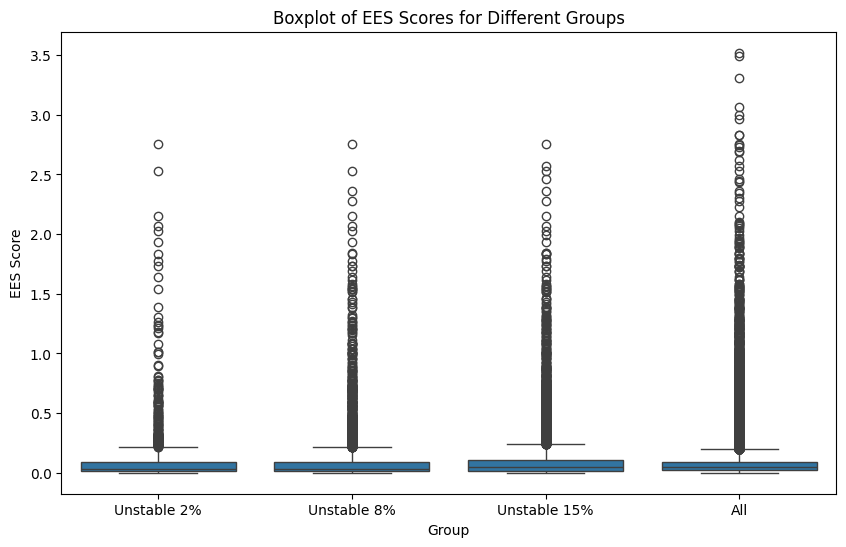

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert numpy arrays to pandas Series if necessary
unstable_4_ees_scores = pd.Series(unstable_4_ees_scores)
unstable_8_ees_scores = pd.Series(unstable_8_ees_scores)
unstable_12_ees_scores = pd.Series(unstable_12_ees_scores)
#unstable_16_ees_scores = pd.Series(unstable_16_ees_scores)
ALL_ees_scores = pd.Series(ees_scores)

# Combine all EES scores using pd.concat
all_ees_values = pd.concat([unstable_4_ees_scores, unstable_8_ees_scores, unstable_12_ees_scores, ALL_ees_scores])

# Create a list of corresponding group labels
group_labels = (['Unstable 2%'] * len(unstable_4_ees_scores) + 
                ['Unstable 8%'] * len(unstable_8_ees_scores) + 
                ['Unstable 15%'] * len(unstable_12_ees_scores) + 
                #['Unstable 16%'] * len(unstable_16_ees_scores) + 
                ['All'] * len(ALL_ees_scores))

# Ensure the lengths of 'all_ees_values' and 'group_labels' match
print(len(all_ees_values), len(group_labels))

# Create a DataFrame to hold the values and their corresponding group labels
df = pd.DataFrame({'EES Score': all_ees_values, 'Group': group_labels})

# Plotting the boxplot for EES scores
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='Group', y='EES Score', data=df)

# Customize plot labels and title
plt.title("Boxplot of EES Scores for Different Groups")
plt.xlabel("Group")
plt.ylabel("EES Score")

# Show the plot
plt.show()


/var/folders/08/dlwtjxd16pq53x_f4yyq0xwc0000gn/T/ipykernel_66057/1193383901.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='EES Score', data=df, palette='Set2')


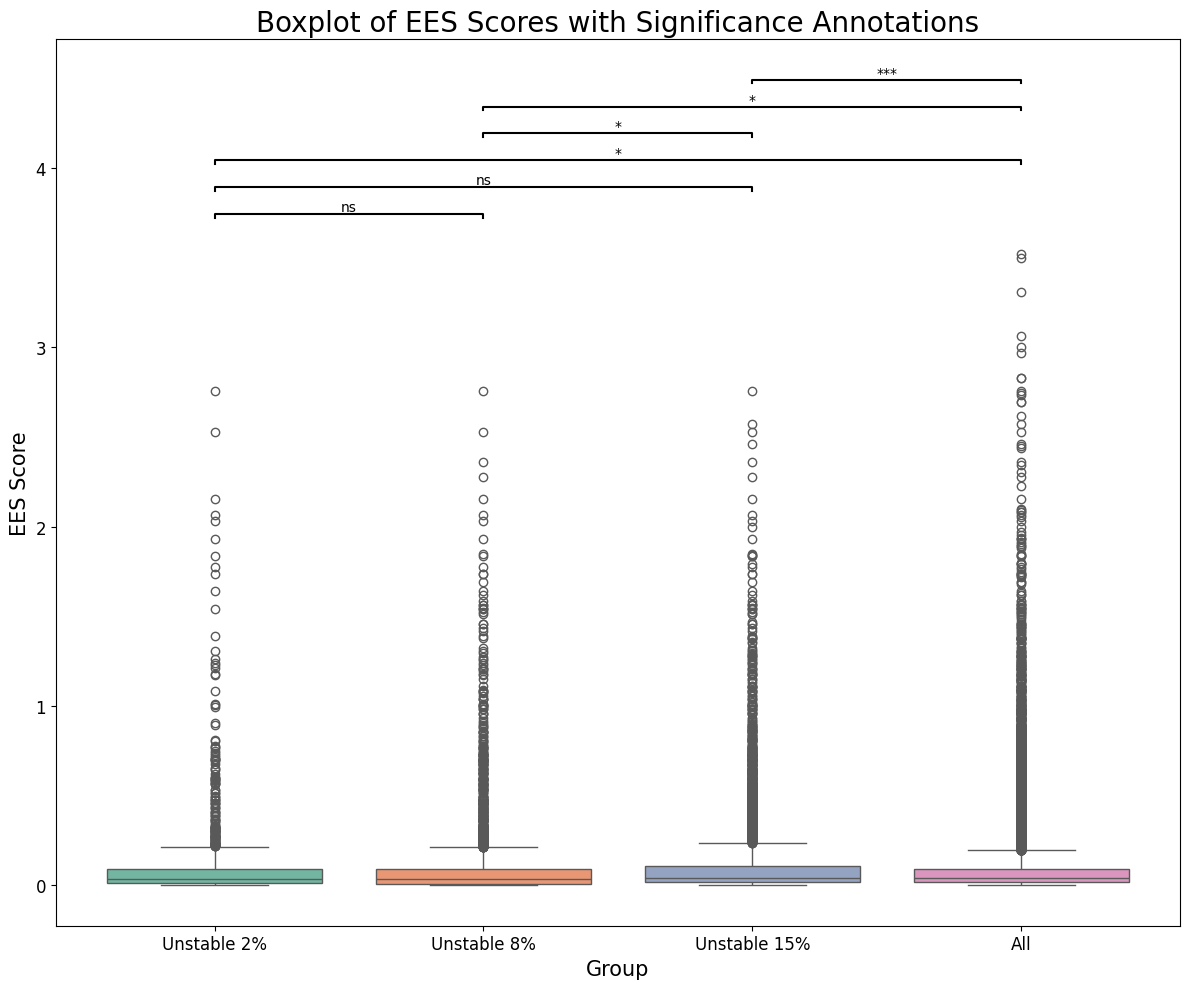

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Assuming EES score data for each group is already defined as numpy arrays:
# unstable_4_ees_scores, unstable_8_ees_scores, unstable_12_ees_scores, ALL_ees_scores

# Convert numpy arrays to pandas Series and then combine them into a single DataFrame
all_ees_values = pd.concat([
    pd.Series(unstable_4_ees_scores),
    pd.Series(unstable_8_ees_scores),
    pd.Series(unstable_12_ees_scores),
    pd.Series(ALL_ees_scores)
])
group_labels = (['Unstable 2%'] * len(unstable_4_ees_scores) +
                ['Unstable 8%'] * len(unstable_8_ees_scores) +
                ['Unstable 15%'] * len(unstable_12_ees_scores) +
                ['All'] * len(ALL_ees_scores))

df = pd.DataFrame({'EES Score': all_ees_values, 'Group': group_labels})

# Create the boxplot
plt.figure(figsize=(12, 10))
ax = sns.boxplot(x='Group', y='EES Score', data=df, palette='Set2')

# Perform t-tests for each pairwise comparison and add significance annotations
def add_stat_annotation(ax, x1, x2, y, label):
    """ Add the significance annotation between x1 and x2 at height y """
    line_offset = 0.02  # Offset for the significance line
    y_offset = y + line_offset
    ax.plot([x1, x1, x2, x2], [y, y_offset, y_offset, y], lw=1.5, c='black')
    ax.text((x1 + x2) * 0.5, y_offset, label, ha='center', va='bottom', color='black')

# Define all pairwise comparisons for the four groups
comparisons = [
    ("Unstable 2%", "Unstable 8%"),
    ("Unstable 2%", "Unstable 15%"),
    ("Unstable 2%", "All"),
    ("Unstable 8%", "Unstable 15%"),
    ("Unstable 8%", "All"),
    ("Unstable 15%", "All")
]

y_max = df['EES Score'].max() + 0.2  # Add more space above the highest data point for annotations

# Iterate over comparisons and add significance annotations to the plot
for i, (group1, group2) in enumerate(comparisons):
    group1_index = df['Group'].unique().tolist().index(group1)
    group2_index = df['Group'].unique().tolist().index(group2)
    
    group1_values = df[df['Group'] == group1]['EES Score']
    group2_values = df[df['Group'] == group2]['EES Score']
    t_stat, p_val = stats.ttest_ind(group1_values, group2_values)
    y = y_max + (i * 0.15)  # Adjust the vertical spacing between the significance markers

    # Annotate significance based on p-value
    if p_val < 0.001:
        add_stat_annotation(ax, group1_index, group2_index, y, "***")
    elif p_val < 0.01:
        add_stat_annotation(ax, group1_index, group2_index, y, "**")
    elif p_val < 0.05:
        add_stat_annotation(ax, group1_index, group2_index, y, "*")
    else:
        add_stat_annotation(ax, group1_index, group2_index, y, "ns")

# Customize and show the plot
plt.title("Boxplot of EES Scores with Significance Annotations", fontsize=20)
plt.xlabel("Group", fontsize=15)
plt.ylabel("EES Score", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



# extract Top n% EES score

In [67]:
import numpy as np
import pandas as pd

# Assuming `ees_scores` is a NumPy array or a Pandas Series containing all the EES scores.
# Convert `ees_scores` to a Pandas Series if it isn't one already.
ees_scores = pd.Series(ees_scores)

# Define the percentages for which we want to extract the EES scores.
percentages = [4, 8, 12, 16]

# Calculate the thresholds for each percentage.
top_4_percent_threshold = np.percentile(ees_scores, 100 - 4)  # Top 4%
top_8_percent_threshold = np.percentile(ees_scores, 100 - 8)  # Top 8%
top_12_percent_threshold = np.percentile(ees_scores, 100 - 12)  # Top 12%
top_16_percent_threshold = np.percentile(ees_scores, 100 - 16)  # Top 16%

# Extract the EES scores greater than or equal to these thresholds.
top_4_percent_scores = ees_scores[ees_scores >= top_4_percent_threshold]
top_8_percent_scores = ees_scores[ees_scores >= top_8_percent_threshold]
top_12_percent_scores = ees_scores[ees_scores >= top_12_percent_threshold]
top_16_percent_scores = ees_scores[ees_scores >= top_16_percent_threshold]

# Print the number of scores in each top percentile group
print(f"Number of scores in top 4%: {len(top_4_percent_scores)}")
print(f"Number of scores in top 8%: {len(top_8_percent_scores)}")
print(f"Number of scores in top 12%: {len(top_12_percent_scores)}")
print(f"Number of scores in top 16%: {len(top_16_percent_scores)}")


Number of scores in top 4%: 1242
Number of scores in top 8%: 2483
Number of scores in top 12%: 3724
Number of scores in top 16%: 4965


In [155]:
import numpy as np
import pandas as pd
from scipy import stats

# Assuming EES score data for the entire dataset is available as a numpy array or Pandas Series
ees_scores = pd.Series(ees_scores)

# Calculate the thresholds for top percentiles
top_4_percent_threshold = np.percentile(ees_scores, 100 - 4)
top_8_percent_threshold = np.percentile(ees_scores, 100 - 8)
top_12_percent_threshold = np.percentile(ees_scores, 100 - 12)
top_16_percent_threshold = np.percentile(ees_scores, 100 - 16)

# Extract the EES scores for each group
top_4_percent_scores = ees_scores[ees_scores >= top_4_percent_threshold]
top_8_percent_scores = ees_scores[ees_scores >= top_8_percent_threshold]
top_12_percent_scores = ees_scores[ees_scores >= top_12_percent_threshold]
top_16_percent_scores = ees_scores[ees_scores >= top_16_percent_threshold]

# Data structure to store t-test results
data = {
    "Comparison": ["Top 4% vs Top 8%", "Top 8% vs Top 12%", "Top 12% vs Top 16%", "Top 16% vs All"],
    "T-statistic": [],
    "P-value": [],
    "99% CI Lower": [],
    "99% CI Upper": []
}

# Function to perform t-test and compute 99% confidence interval
def perform_ttest_to_table(group1, group2):
    # Perform the two-sample t-test
    t_stat, p_value = stats.ttest_ind(group1, group2)
    
    # Calculate mean difference and standard error
    mean_diff = np.mean(group1) - np.mean(group2)
    std_err_1 = np.std(group1, ddof=1) / np.sqrt(len(group1))
    std_err_2 = np.std(group2, ddof=1) / np.sqrt(len(group2))
    std_err_diff = np.sqrt(std_err_1**2 + std_err_2**2)
    
    # Degrees of freedom
    df = len(group1) + len(group2) - 2
    
    # T-critical value for 99% confidence interval
    t_critical = stats.t.ppf(1 - 0.005, df)
    
    # Calculate 99% confidence interval
    ci_lower = mean_diff - t_critical * std_err_diff
    ci_upper = mean_diff + t_critical * std_err_diff
    
    return t_stat, p_value, ci_lower, ci_upper

# Perform the comparisons and add to the table
comparisons = [
    (top_4_percent_scores, top_8_percent_scores),
    (top_8_percent_scores, top_12_percent_scores),
    (top_12_percent_scores, top_16_percent_scores),
    (top_16_percent_scores, ees_scores)
]

for group1, group2 in comparisons:
    t_stat, p_value, ci_lower, ci_upper = perform_ttest_to_table(group1, group2)
    data["T-statistic"].append(t_stat)
    data["P-value"].append(p_value)
    data["99% CI Lower"].append(ci_lower)
    data["99% CI Upper"].append(ci_upper)

# Convert the data dictionary to a pandas DataFrame
results_df = pd.DataFrame(data)

# Print the t-test results
print(results_df)


           Comparison  T-statistic        P-value  99% CI Lower  99% CI Upper
0    Top 4% vs Top 8%     7.446404   5.621255e-13      0.006216      0.012509
1   Top 8% vs Top 12%     5.715805   1.625239e-08      0.003141      0.008237
2  Top 12% vs Top 16%     4.941112   9.152148e-07      0.002056      0.006503
3      Top 16% vs All    36.889918  1.054213e-256      0.036948      0.040592


/var/folders/08/dlwtjxd16pq53x_f4yyq0xwc0000gn/T/ipykernel_66451/2932027709.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='EES Score', data=df, palette='Set2')


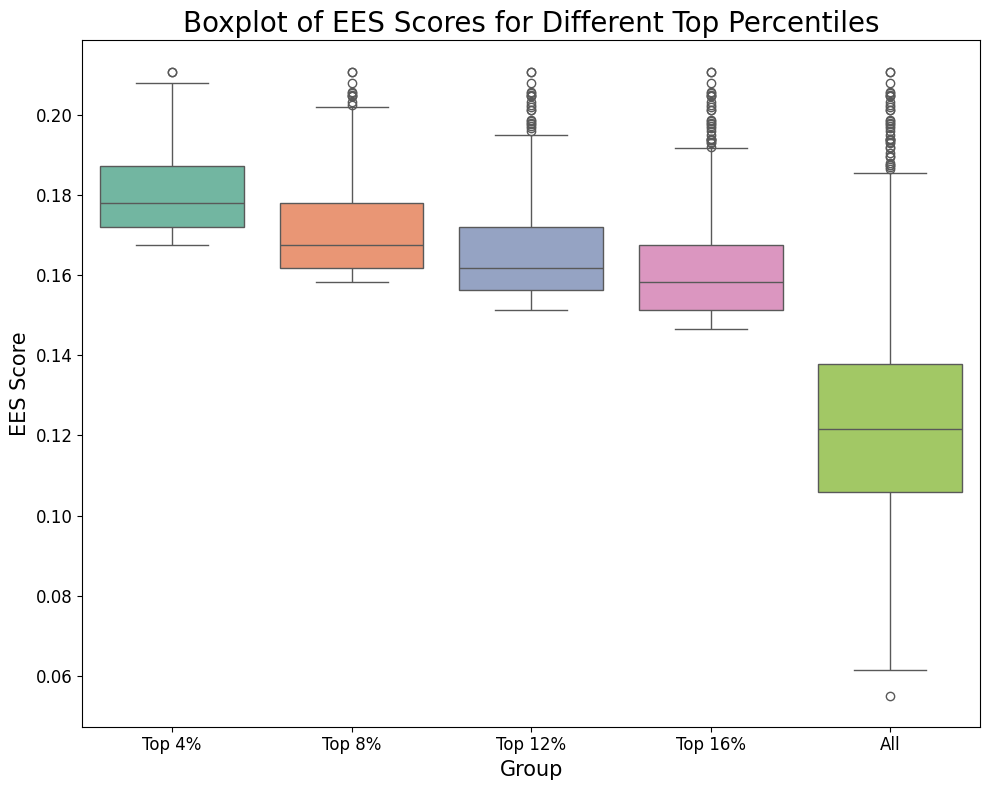

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine all EES scores using pd.concat
all_ees_values = pd.concat([
    top_4_percent_scores,
    top_8_percent_scores,
    top_12_percent_scores,
    top_16_percent_scores,
    ees_scores
])

# Create a list of corresponding group labels
group_labels = (['Top 4%'] * len(top_4_percent_scores) +
                ['Top 8%'] * len(top_8_percent_scores) +
                ['Top 12%'] * len(top_12_percent_scores) +
                ['Top 16%'] * len(top_16_percent_scores) +
                ['All'] * len(ees_scores))

# Create a DataFrame to hold the values and their corresponding group labels
df = pd.DataFrame({'EES Score': all_ees_values, 'Group': group_labels})

# Plotting the boxplot for EES scores
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='Group', y='EES Score', data=df, palette='Set2')

# Customize plot labels and title
plt.title("Boxplot of EES Scores for Different Top Percentiles", fontsize=20)
plt.xlabel("Group", fontsize=15)
plt.ylabel("EES Score", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/08/dlwtjxd16pq53x_f4yyq0xwc0000gn/T/ipykernel_66451/4268515031.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='EES Score', data=df, palette='Set2')


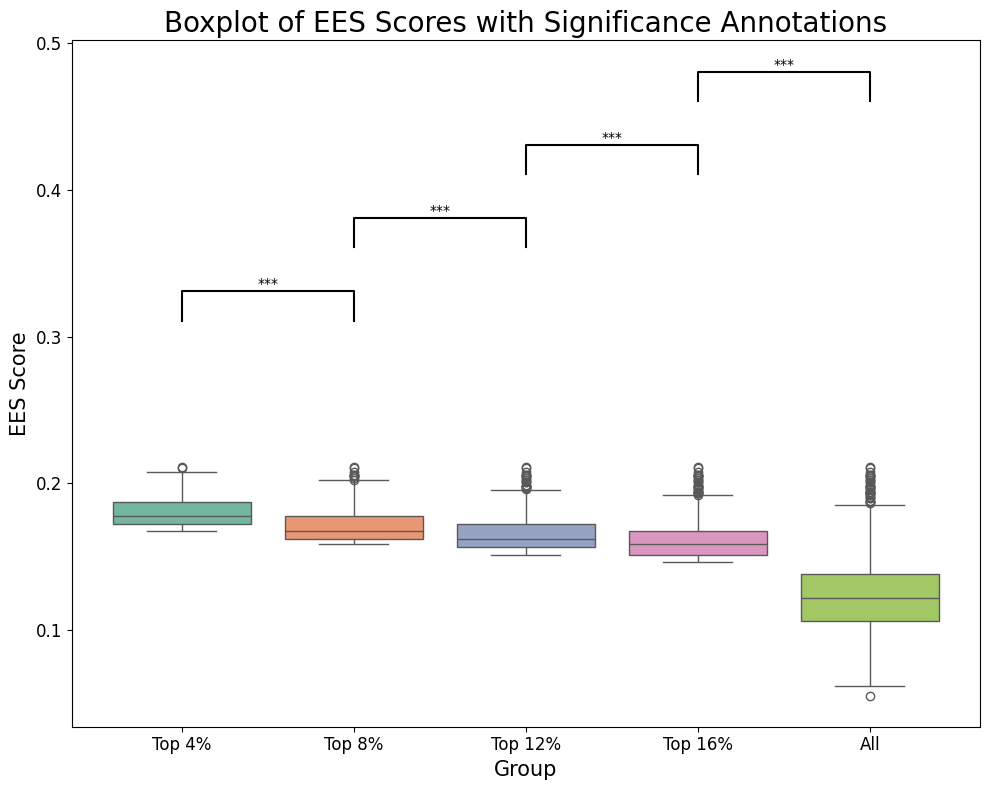

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Assuming that `df` contains the EES scores for different groups ('Top 4%', 'Top 8%', etc.)
# and `ax` is the axis containing the boxplot

# Function to add significance annotations to the boxplot using categorical x-axis positions
def add_stat_annotation(ax, group1, group2, y, label):
    """ Add the significance annotation between group1 and group2 at height y """
    # Get the position of the groups on the x-axis
    tick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    x1 = tick_labels.index(group1)
    x2 = tick_labels.index(group2)
    
    # Set offset for the significance line and position text annotation
    line_offset = 0.02  # Offset for the significance line
    y_offset = y + line_offset
    ax.plot([x1, x1, x2, x2], [y, y_offset, y_offset, y], lw=1.5, c='black')
    ax.text((x1 + x2) * 0.5, y_offset, label, ha='center', va='bottom', color='black')

# Create the boxplot
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='Group', y='EES Score', data=df, palette='Set2')

# Define the pairwise comparisons for EES groups
comparisons = [
    ('Top 4%', 'Top 8%'),
    ('Top 8%', 'Top 12%'),
    ('Top 12%', 'Top 16%'),
    ('Top 16%', 'All')
]

# Maximum value for y-axis adjustment
y_max = df['EES Score'].max() + 0.1  # Add some space above the highest data point for annotations

# Iterate over comparisons and add significance annotations to the plot
for i, (group1, group2) in enumerate(comparisons):
    group1_values = df[df['Group'] == group1]['EES Score']
    group2_values = df[df['Group'] == group2]['EES Score']
    t_stat, p_val = stats.ttest_ind(group1_values, group2_values)
    y = y_max + (i * 0.05)  # Adjust the vertical spacing between the significance markers

    # Annotate significance based on p-value
    if p_val < 0.01:
        add_stat_annotation(ax, group1, group2, y, "***")
    elif p_val < 0.05:
        add_stat_annotation(ax, group1, group2, y, "**")
    else:
        add_stat_annotation(ax, group1, group2, y, "ns")

# Customize and show the plot
plt.title("Boxplot of EES Scores with Significance Annotations", fontsize=20)
plt.xlabel("Group", fontsize=15)
plt.ylabel("EES Score", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot with annotations
plt.tight_layout()
plt.show()


# finding EES score distribution for different cell type

In [48]:
# Ensure both columns have the same data type
df['Original_Index'] = df['Original_Index'].astype(int)  # Convert to int if needed
cell_type_df.index = cell_type_df.index.astype(int)  # Ensure the index is int

# Merge the DataFrames
df = df.merge(cell_type_df, left_on='Original_Index', right_index=True, how='left')

df['Inverse_Score'] = 1 / df['Scores']

# Display the updated DataFrame
print(df)


         Scores  Original_Index  cell_type  Inverse_Score
0      0.009787               0        ESC     102.173575
1      0.021427               1        ESC      46.669303
2      0.029494               2        ESC      33.905309
3      0.091561               3        ESC      10.921725
4      0.054508               4        ESC      18.346060
...         ...             ...        ...            ...
31024  0.008674           31024  NE-1/NS-5     115.288523
31025  0.008060           31025        CPs     124.063930
31026  0.004832           31026       SMPs     206.934135
31027  0.004361           31027       SMPs     229.309762
31028  0.185281           31028       SMPs       5.397205

[31029 rows x 4 columns]


In [ ]:
df.to_csv('embryoid_body_EMBEDR_EES_score.csv', index=False)
print("DataFrame saved as 'embryoid_body_EMBEDR_EES_score.csv'")


DataFrame saved as 'updated_dataframe.csv'


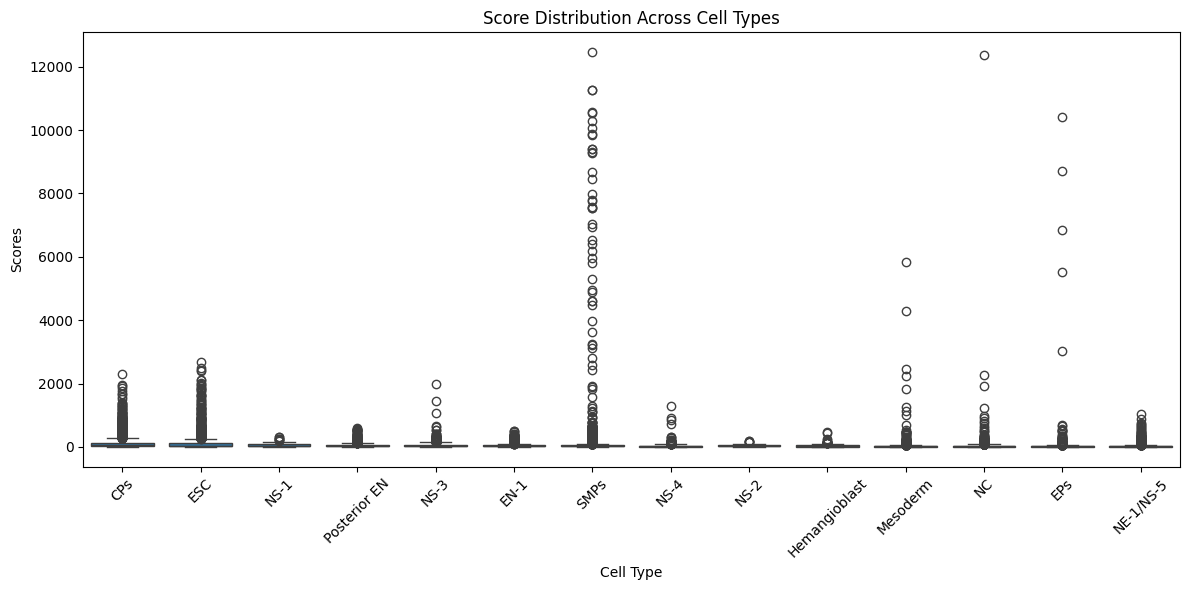

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean scores for each cell type
sorted_cell_types = df.groupby('cell_type')['Inverse_Score'].median().sort_values(ascending=False).index

# Create the box plot with sorted cell types
plt.figure(figsize=(12, 6))  # Adjust the figure size
sns.boxplot(x='cell_type', y='Inverse_Score', data=df, order=sorted_cell_types)

# Add labels and a title
plt.xlabel('Cell Type')
plt.ylabel('Scores')
plt.title('Score Distribution Across Cell Types')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

